In [2]:
pip install --upgrade scikit-learn

  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Set up & handling the data
import os
os.chdir('C:\\Users\\M246047\\Documents\\Python')
import csv
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action="ignore")

# Transforming the data
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn import ensemble   # we'll use ensemble random forests, gradient booster regressor

# Running the models
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression

#Statistics
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Introduction

Analyzing the [IMDB Movie dataset](https://www.kaggle.com/jyoti1706/imdbmoviesdataset) found on Kaggle, I'm going to look whether I can predict how successful a movie is using the adjusted revenue as the measure of success, as this variable allows all movies to be comparable. With nearly 11,000 movies and twenty variables, I should be able to choose features correlated with the revenue to create a good model. 

# Cleaning

There are 6,016 rows with an adjused revenue of $0. I'm going to remove these rows as they do not contain the target variable. Of the remaining rows, there are nearly 100 with adjusted revenue under $10,000. I've investigated these individual movies and updated those that were incorrect and confirmed the others.

Columns homepage, director, cast, keywords, tagline, and production_companies are missing values. For the homepage column, I will assume a missing value indicates that a movie does not have a homepage. I'll create a dummy variable in which 0 indicates there is no homepage and 1 indicates that one exists. Only one movie is missing the director and five movies are missing the cast, so I will look up this information and manually add it to the dataset. I will set cells missing values for keywords, tagline, and production companies to 'Unknown'. Additionally, popularity, budget, revenue, runtime, and votecount have clear high outliers. I'm going to take a look at these columns and see if I can derive what may be going on.



In [2]:
movies = pd.read_csv('IMDBMovies.csv', encoding = 'utf-8')
movies = pd.DataFrame(movies)
print(movies.columns)
print('\n', movies.describe())
movies.info()

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

               id  popularity        budget        revenue   runtime  \
count  10866.000   10866.000     10866.000      10866.000 10866.000   
mean   66064.177       0.646  14625701.094   39823319.793   102.071   
std    92130.137       1.000  30913213.831  117003486.582    31.381   
min        5.000       0.000         0.000          0.000     0.000   
25%    10596.250       0.208         0.000          0.000    90.000   
50%    20669.000       0.384         0.000          0.000    99.000   
75%    75610.000       0.714  15000000.000   24000000.000   111.000   
max   417859.000      32.986 425000000.000 2781505847.000   900.000   

       vote_count  vote_ave

In [3]:
pd.options.display.max_columns = None
movies[movies['revenue_adj'] == 0 ].shape
movies = movies[movies.revenue_adj != 0]
print(movies.describe())
movies.info()
movies.head()

              id  popularity        budget        revenue  runtime  \
count   4850.000    4850.000      4850.000       4850.000 4850.000   
mean   44575.001       1.045  29569700.632   89220658.325  107.965   
std    72361.406       1.357  40513434.965  162068389.382   21.113   
min        5.000       0.001         0.000          2.000   15.000   
25%     8286.000       0.388   1700000.000    7708081.250   95.000   
50%    12154.500       0.680  15000000.000   31826540.000  104.000   
75%    43956.500       1.210  40000000.000   99918234.250  117.000   
max   417859.000      32.986 425000000.000 2781505847.000  705.000   

       vote_count  vote_average  release_year    budget_adj    revenue_adj  
count    4850.000      4850.000      4850.000      4850.000       4850.000  
mean      436.216         6.149      2000.922  35161017.182  115077354.868  
std       806.416         0.799        11.569  43756717.053  198841916.046  
min        10.000         2.100      1960.000         0.000  

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000


In [4]:
# Updating incorrect entries in target variable.
movies.at[5067, 'revenue_adj'] = 2944752
movies.at[8142, 'revenue_adj'] = 2122561
movies.at[3239, 'revenue_adj'] = 3800000
movies.at[5162, 'revenue_adj'] = 0
movies.at[8523, 'revenue_adj'] = 5600000
movies.at[8226, 'revenue_adj'] = 6858261
movies.at[10307, 'revenue_adj'] = 6265311
movies.at[3283, 'revenue_adj'] = 11500000
movies.at[2252, 'revenue_adj'] = 18000
movies.at[5852, 'revenue_adj'] = 0
movies.at[1380, 'revenue_adj'] = 4000000
movies.at[7158, 'revenue_adj'] = 12313323
movies.at[8328, 'revenue_adj'] = 9200000
movies.at[3853, 'revenue_adj'] = 0
movies.at[10607, 'revenue_adj'] = 11800000
movies.at[8235, 'revenue_adj'] = 6858261
movies.at[2519, 'revenue_adj'] = 13042112
movies.at[9109, 'revenue_adj'] = 15923122
movies.at[9390, 'revenue_adj'] = 13878334
movies.at[10294, 'revenue_adj'] = 15935068

In [5]:
movies.at[8125, 'revenue_adj'] = 16115878
movies.at[10050, 'revenue_adj'] = 16324573
movies.at[5060, 'revenue_adj'] = 4750602
movies.at[4675, 'revenue_adj'] = 30932113
movies.at[10045, 'revenue_adj'] = 22305841
movies.at[8944, 'revenue_adj'] = 16100000
movies.at[10777, 'revenue_adj'] = 36000000
movies.at[10297, 'revenue_adj'] = 40750000
movies.at[2398, 'revenue_adj'] = 43294943
movies.at[8599, 'revenue_adj'] = 44847000
movies.at[9401, 'revenue_adj'] = 46432000
movies.at[7506, 'revenue_adj'] = 48377000
movies.at[10236, 'revenue_adj'] = 63398000
movies.at[7901, 'revenue_adj'] = 67169000
movies.at[1900, 'revenue_adj'] = 84000
movies.at[6011, 'revenue_adj'] = 599840
movies.at[5785, 'revenue_adj'] = 1471106
movies.at[5777, 'revenue_adj'] = 127257
movies.at[9332, 'revenue_adj'] = 124885000
movies.at[2618, 'revenue_adj'] = 6552255

In [6]:
movies.at[1733, 'revenue_adj'] = 404099
movies.at[6707, 'revenue_adj'] = 155760000
movies.at[5834, 'revenue_adj'] = 228004
movies.at[3698, 'revenue_adj'] = 213000000
movies.at[4970, 'revenue_adj'] = 296338000
movies.at[9992, 'revenue_adj'] = 333780000
movies.at[9580, 'revenue_adj'] = 444378
movies.at[4682, 'revenue_adj'] = 498.616
movies.at[5669, 'revenue_adj'] = 5990.997
movies.at[4665, 'revenue_adj'] = 712216
movies.at[5637, 'revenue_adj'] = 757251
movies.at[4667, 'revenue_adj'] = 1026.674
movies.at[2273, 'revenue_adj'] = 1279.000
movies.at[3581, 'revenue_adj'] = 1926
movies.at[4909, 'revenue_adj'] = 1632
movies.at[4668, 'revenue_adj'] = 1938
movies.at[4611, 'revenue_adj'] = 2521
movies.at[1156, 'revenue_adj'] = 2496.157
movies.at[1033, 'revenue_adj'] = 2756
movies.at[4495, 'revenue_adj'] = 3003

In [7]:
movies.at[4591, 'revenue_adj'] = 3010
movies.at[3621, 'revenue_adj'] = 3358
movies.at[3692, 'revenue_adj'] = 3838
movies.at[7602, 'revenue_adj'] = 5665
movies.at[2078, 'revenue_adj'] = 3826
movies.at[5684, 'revenue_adj'] = 4187
movies.at[378, 'revenue_adj'] = 4444
movies.at[294, 'revenue_adj'] = 4505
movies.at[5918, 'revenue_adj'] = 4916

In [8]:
movies = movies[movies.revenue_adj != 0]
print(len(movies.loc[movies['revenue_adj'] < 10000].sort_values('revenue_adj')))
pd.options.display.max_columns = None
movies.loc[movies['revenue_adj'] < 10000].sort_values('revenue_adj')


49


,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
3968,4614,tt0164184,0.958,68,193,The Sum of All Fears,Ben Affleck|Morgan Freeman|James Cromwell|Ken ...,http://www.paramount.com/movies/sum-all-fears,Phil Alden Robinson,"27,000 nuclear weapons. One is missing.",cia|terrorist|atomic bomb|cold war|nuclear exp...,CIA analyst Jack Ryan discovers that an Islami...,124,Thriller|Action|Drama,Paramount Pictures|Mace Neufeld Productions|MF...,5/31/2002,256,5.700,2002,82.434,233.966
4682,94204,tt1810697,0.153,0,525,Meeting Evil,Leslie Bibb|Samuel L. Jackson|Luke Wilson|Peyt...,NaN,Chris Fisher,NaN,NaN,Follows disillusioned young family man John as...,89,Crime|Drama|Mystery|Thriller,Sony Pictures,5/3/2012,29,4.400,2012,0.000,498.616
4667,101176,tt1612782,0.322,0,1081,The Butterfly Room,Barbara Steele|Julia Putnam|Ellery Sprayberry|...,NaN,Jonathan Zarantonello,Kids should never grow up,NaN,"Ann, a reclusive elegant lady, with an obsessi...",87,Horror|Thriller,Rai Cinema|Achab Film|Wiseacre Films|Emergency...,8/4/2012,24,5.700,2012,0.000,1026.674
2273,59435,tt1212454,0.218,0,1279,An Invisible Sign,Jessica Alba|Bailee Madison|J.K. Simmons|Chris...,http://www.ifcfilms.com/films/an-invisible-sign,Marilyn Agrelo,Count on the unexpected.,mathematician|elementary school|independent fi...,"Mona Gray is a 20-year-old loner who, as a chi...",96,Family|Drama|Romance|Comedy,Silverwood Films|iDeal Partners Film Fund|J2 P...,10/6/2010,26,4.900,2010,0.000,1279.000
4909,100275,tt1480658,0.029,0,1632,Eddie: The Sleepwalking Cannibal,Thure Lindhardt|Dylan Smith|Georgina Reilly|Al...,NaN,Boris Rodriguez,Part muse. Part sleepwalking cannibal.,NaN,A once-famous painter rediscovers inspiration ...,79,Horror|Comedy,Det Danske Filminstitut|Téléfilm Canada|Fridth...,4/22/2012,16,6.100,2012,0.000,1632.000
3581,59296,tt1436559,0.520,1,1378,"Love, Wedding, Marriage",Mandy Moore|Kellan Lutz|Jessica Szohr|Autumn F...,http://www.ifcfilms.com/films/love-wedding-mar...,Dermot Mulroney,Here comes the ride.,wedding vows|marriage|love,A happy newlywed marriage counselor's views on...,90,Comedy|Romance,120dB Films|Scion Films|Voodoo Production Serv...,6/3/2011,55,5.300,2011,0.969,1926.000
4668,138222,tt1885300,0.322,1500000,1938,Best Man Down,Justin Long|Jess Weixler|Tyler Labine|Addison ...,NaN,Ted Koland,NaN,NaN,A newlywed couple cancels their honeymoon and ...,90,Comedy|Drama,KODA Entertainment,10/20/2012,39,5.900,2012,1424616.422,1938.000
1156,278632,tt2582426,0.241,0,2710,Julia,Ashley C. Williams|Tahyna Tozzi|Jack Noseworth...,http://tombstonedistribution.com/julia/,Matthew A. Brown,NaN,nurse|rape|plastic surgery|castration|revenge,"After suffering a brutal trauma, Julia uses an...",95,Thriller|Horror,Zero Gravity Management|Farraj Factory|Kinetic...,10/14/2014,17,4.800,2014,0.000,2496.157
4611,98339,tt1867093,0.402,12000000,2521,The Samaritan,Samuel L. Jackson|Luke Kirby|Ruth Negga|Tom Wi...,http://www.thesamaritanfilm.com/,David Weaver,NaN,prison|sex|revenge|incest|grifter,"After twenty years in prison, Foley is finishe...",90,Thriller,Quickfire Films|H2O Motion Pictures|2262730 On...,3/2/2012,27,4.700,2012,11396931.380,2521.000
1033,267806,tt3704538,0.290,0,2756,V/H/S: Viral,Justin Welborn|Emmy Argo|Gustavo Salmerón|Nick...,NaN,Nacho Vigalondo|Marcel Sarmiento|Gregg Bishop|...,NaN,mumblegore,V/H/S: VIRAL's segments include the story of a...,81,Horror|Thriller,Bloody Disgusting|8383 Productions,10/23/2014,105,4.200,2014,0.000,2756.000


## Genres Variable

The contents in the genres column contain multiple genres separated by the '|' symbol. I'm going to separate the genres in each cell, find all unique values, and create a dummy column for each genre. If a movie contains that genre, the column will have the value one in the corresponding cell. Otherwise, the genre column for that movie will contain a zero.

In [9]:
# Create a list of genres

Genres = movies.genres.unique()
genres = []
flatten_genres = []

for list_of_genres in Genres:
    movies_genres = list_of_genres.split('|')
    genres.append(movies_genres)
    for i in range(len(genres)): #Traversing through the main list
        for j in range (len(genres[i])): #Traversing through each sublist
            flatten_genres.append(genres[i][j]) #Appending elements into our flat_list

unique_genres = set(flatten_genres)
print(unique_genres)

# Creating dummy columns for each genre
for genre in unique_genres:
    movies[genre] = 0

{'Science Fiction', 'Documentary', 'Crime', 'Comedy', 'War', 'Western', 'TV Movie', 'Family', 'Romance', 'Music', 'Fantasy', 'Drama', 'Adventure', 'Mystery', 'Thriller', 'Action', 'History', 'Animation', 'Horror', 'Foreign'}


In [10]:
# Populating each genre column
def populating_genres(df, genre_list):
    for i, row in df.iterrows():
        movies_genres = df.loc[i]['genres']
        for genre in genre_list:
            if genre in movies_genres:
                df.at[i, genre] = 1
    return df

populating_genres(movies, unique_genres)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Science Fiction,Documentary,Crime,Comedy,War,Western,TV Movie,Family,Romance,Music,Fantasy,Drama,Adventure,Mystery,Thriller,Action,History,Animation,Horror,Foreign
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
5,281957,tt1663202,9.111,135000000,532950503,The Revenant,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,http://www.foxmovies.com/movies/the-revenant,Alejandro González Iñárritu,"(n. One who has returned, as if from the dead.)",father-son relationship|rape|based on novel|mo...,"In the 1820s, a frontiersman, Hugh Glass, sets...",156,Western|Drama|Adventure|Thriller,Regency Enterprises|Appian Way|CatchPlay|Anony...,12/25/2015,3929,7.200,2015,124199945.400,490314247.000,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0
6,87101,tt1340138,8.654,155000000,440603537,Terminator Genisys,Arnold Schwarzenegger|Jason Clarke|Emilia Clar...,http://www.terminatormovie.com/,Alan Taylor,Reset the future,saving the world|artificial intelligence|cybor...,"The year is 2029. John Connor, leader of the r...",125,Science Fiction|Action|Thriller|Adventure,Paramount Pictures|Skydance Productions,6/23/2015,2598,5.800,2015,142599937.300,405355075.700,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0
7,286217,tt3659388,7.667,108000000,595380321,The Martian,Matt Damon|Jessica Chastain|Kristen Wiig|Jeff ...,http://www.foxmovies.com/movies/the-martian,Ridley Scott,Bring Him Home,based on novel|mars|nasa|isolation|botanist,"During a manned mission to Mars, Astronaut Mar...",141,Drama|Adventure|Science Fiction,Twentieth Century Fox Film 

## Cast Variable

Each cell in the cast column has up to the five central actors and/or actresses in the movie. I have found a list of the top 100 movie stars from 1960, the year of the oldest movie, and to make use of this variable, I will create a new feature called 'top_100_actors' which holds the number of actors each movie has from this list. We would expect to see that movies with any/more stars than others would be more successful.

The list I used had replaced many letters containing accents (ex. á, å, etc.) with incorrect characters, so I used a list comprehension to filter these names and updated them directly in the csv. 

In [11]:
# Adding the missing top five cast members
movies[movies['cast'].isnull()]
movies.at[1088, 'cast'] = 'Vivian Maier|John Maloof|Daniel Arnaud|Simone Amédé|Maren Baylaender'
movies.at[4127, 'cast'] = 'Belladonna|Marlon Brando|Elton John|Julia Louis-Dreyfus|Madonna'
movies.at[4889, 'cast'] = 'Jay Bastian|Joe Biden|Cait Brasel|Gene Burris Jr.|Dinesh D\'Souza'
movies.at[7813, 'cast'] = 'Dylan Avery|Mahmoud Ahmad|Ahmed Al-Ghamdi|Hamza Al-Ghamdi|Saeed Al-Ghamdi'
movies.at[9564, 'cast'] = 'Christie Brinkley|David Brinkley|Pope John Paul II|Dan Rather|Cheryl Tiegs'
movies[movies['cast'].isnull()]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Science Fiction,Documentary,Crime,Comedy,War,Western,TV Movie,Family,Romance,Music,Fantasy,Drama,Adventure,Mystery,Thriller,Action,History,Animation,Horror,Foreign


In [12]:
# Splitting the cast information into lists
movies['cast'] = movies['cast'].apply(lambda x: x.split('|'))

In [13]:
## Create a list of actors

Cast = movies.cast
cast = []
flatten_cast = []

for list_of_actors in Cast: 
    cast.append(list_of_actors)
    for i in range(len(cast)): #Traversing through the main list
        for j in range (len(cast[i])): #Traversing through each sublist
            flatten_cast.append(cast[i][j]) #Appending elements into our flat_list

unique_actors = set(flatten_cast)

In [14]:
# cleaning names - finding actor's names with non-alphanumeric characters
unique_actors = list(unique_actors)
print(type(unique_actors)) 
non_alphanumeric = [i for i in unique_actors if not i.lower().replace(" ", "").replace('\'', '').replace('.', '')
                    .replace('-', '').replace(',','').replace('ÃƒÂ¥', 'å').replace('ÃƒÂ¡', 'á').replace('ÃƒÂ\xad', 'í')
                    .isalpha()]
print('\n \n Names with non-alphanumeric characters:\n ', non_alphanumeric)


<class 'list'>

 
 Names with non-alphanumeric characters:
  ['50 Cent', 'JōÂ«rōta Kosugi', 'Linh āan PhÃ¡ÂºÂ¡m', 'Ã\xa0Â¸ÂªÃ\xa0Â¸Â£Ã\xa0Â¸Å¾Ã\xa0Â¸â€¡Ã\xa0Â¸Â©Ã\xa0Â¹Å’ Ã\xa0Â¸Å\xa0Ã\xa0Â¸Â²Ã\xa0Â¸â€¢Ã\xa0Â¸Â£Ã\xa0Â¸Âµ', 'āềâ€” Thềâ€¹ HÃ¡ÂºÂ£i YÃ¡ÂºÂ¿n', 'Jordi MollÃƒÂ\xa0', 'Antonio SabÃƒÂ\xa0to, Jr.']


In [15]:
# Importing the top 100 stars and removing 'Actor' and 'Actress' so we just have names in the stars dataframe

top_100_actors = pd.read_csv('top_100_stars.csv')
top_100_actors = pd.DataFrame(top_100_actors)


top_100_actors['Name'] = top_100_actors['Name'].str.replace(' Actor', '')
top_100_actors['Name'] = top_100_actors['Name'].str.replace(' Actress', '')

# Converting the series to a list so we can compare it to the cast lists
top_100_actors = top_100_actors['Name'].tolist()
top_100_actors[:5]

movies['top_100_actors'] = [len(set(i) & set(top_100_actors)) for i in movies['cast']]
print('Number of movies for each number of stars (0-5): \n', movies.top_100_actors.value_counts())

Number of movies for each number of stars (0-5): 
 0    4019
1     679
2     134
3      14
4       1
Name: top_100_actors, dtype: int64


## Tagline Variable

For this variable, I will create a new column called 'tagline_length' for the number of words in the tagline to see if there is any correlation between tagline length and revenue. A cell will contain a zero if there is no taglien, a 1 if there are fewer than six words in the tagline, and a two if there are more, and a two if there are more than six words. My hypothesis is that movies with shorter taglines fare better - short and sweet is key!

In [16]:
# movies['tagline'] = movies['tagline'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
# movies['tagline'] = movies['tagline'].str.split(' ')
movies['tagline_length'] = movies['tagline'].str.count(' ') + 1
movies.tagline_length.fillna(0 , inplace=True)
# movies['tagline_length'] = movies['tagline'].apply(lambda x: 1 if len(x) < 6  else 2 if len(x) >= 6 else 0)
movies.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Science Fiction,Documentary,Crime,Comedy,War,Western,TV Movie,Family,Romance,Music,Fantasy,Drama,Adventure,Mystery,Thriller,Action,History,Animation,Horror,Foreign,top_100_actors,tagline_length
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,4.000
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,4.000
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,"[Shailene Woodley, Theo James, Kate Winslet, A...",http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,5.000
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,5.000
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,3.000


# Homepage Variable

I will create a dummy variable that reflects whether or not a movie has a homepage. This column will contain a one if a movie has a homepage and a zero if it does not.

In [17]:
movies['homepage_dummy'] = movies['homepage'].apply(lambda x: 0 if pd.isnull(x) else 1)

## Production Companies Variable

I'm not sure yet how to handle this variable, but will fill any empty cells with 'Unknown' for now.

In [18]:
movies['production_companies'] = movies['production_companies'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
print('There are', len(movies['production_companies'].unique()), 'production companies.')

There are 3681 production companies.


## Keywords Variable

I'm not sure yet how to handle this variable, but will fill any empty cells with 'Unknown' for now.

In [19]:
movies['keywords'] = movies['keywords'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
print('There are', len(movies[movies['keywords'] == 'Unknown']), 'movies with no keywords.')

There are 234 movies with no keywords.


## Director Variable

One movie is missing its director, so I will manually add it.

In [20]:
movies.director.isnull()
movies.at[1088, 'director'] = 'Aziz Mirza'
print('There are', len(movies.director.unique()), 'unique directors.')

There are 2132 unique directors.


## Correlation Matrix

Our first look at the correlation heatmap provides some insight into the relationships between the variables and our target, the adjusted revenue. There are strong relationships between budget_adj and popularity which is intuitive, but there's an even stronger correlation between budget_adj and vote count, stronger even than the average vote and vote count which is interesting. Vote count and popularity (the average number of visits the IMDB page receives per week) are strongly correlated so I'm going to combine them into a single feature. Family and Animation genres have a fairly strong correlation at 0.516, so I may combine them as well.

The features I'll start with are vc_pop (the combination of vote_count and popularity), budget_adj, runtime, vote_average, top_100_actors, and Adventure. 

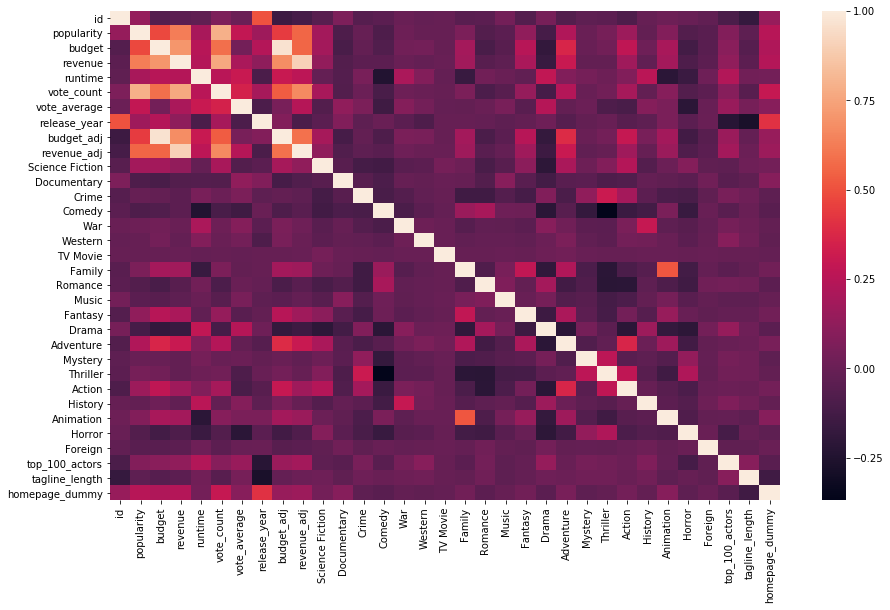

In [21]:
plt.figure(figsize=(15,9))
sns.heatmap(movies.corr())

## Visualizing the relationships between variables and the target

The graphs below give a nice visual of variables with the highest correlations of the target. While it's interesting that there's a higher correlation between vote_count and popularity than vote_average and popularity, I imagine this is a case of 'any press is good press' - more individuals voting on a movie indicates that more individuals have seen and spent money on the movie. 

Unsurprisingly, movies with a higher adjusted budjet tend to have higher adjusted revenue. It stands to reason that the higher a movie's budget, the more opportunies and the higher the quality (production, cast, etc.) the movie can have.

Finally, we can see there's a slight increase in the adjusted revenue as the number of actors in the top_100_actors list increases.

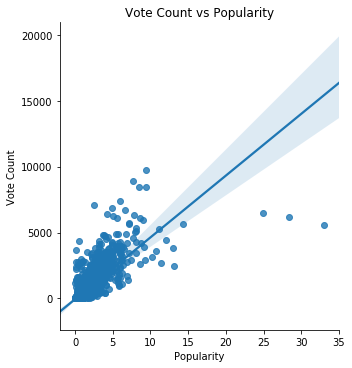

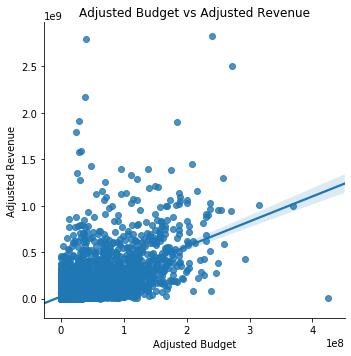

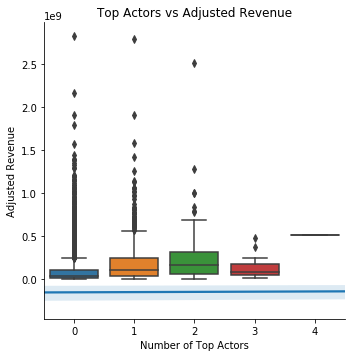

In [22]:
sns.lmplot(x='popularity', y='vote_count', data=movies)
plt.title('Vote Count vs Popularity')
plt.xlabel('Popularity')
plt.ylabel('Vote Count')

sns.lmplot(x='budget_adj', y='revenue_adj', data=movies)
plt.title('Adjusted Budget vs Adjusted Revenue')
plt.xlabel('Adjusted Budget')
plt.ylabel('Adjusted Revenue')

sns.lmplot(x='runtime', y='revenue_adj', data=movies)
plt.title('Runtime vs Adjusted Revenue')
plt.xlabel('Runtime in Minutes')
plt.ylabel('Adjusted Revenue')

sns.boxplot(x='top_100_actors', y='revenue_adj', data=movies)
plt.title('Top Actors vs Adjusted Revenue')
plt.xlabel('Number of Top Actors')
plt.ylabel('Adjusted Revenue')
plt.show()

In [23]:
movies['vc_pop'] = movies['vote_count'] * movies['popularity']
corr_mat = movies.corr().loc[:, ["revenue_adj"]].sort_values(by='revenue_adj', ascending=False)
corr_mat

,revenue_adj
revenue_adj,1.000
revenue,0.904
vote_count,0.666
budget_adj,0.593
popularity,0.561
budget,0.561
vc_pop,0.478
Adventure,0.306
runtime,0.264
vote_average,0.243


## Testing for Outliers and Normality

The Jarque Bera and Normality tests provide very large t-values and very small p-values, confirming that our variables are not normal.

A note on outliers: the extreme values in vc_pop seem to be legitimate - neither the vote_count nor the popularity appear to be errors. Additionally, I've confirmed the extreme values in budget_adj for the movies with the ten highest budgets.

In [24]:
# Testing for Normality
features_to_test = features_to_test = ['revenue_adj','vc_pop', 'budget_adj', 'runtime', 'vote_average', 'top_100_actors']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on revenue_adj:
Jarque-Bera test statistics for revenue_adj is 226661.1194330757 and p value is 0.0
Normality test statistics for revenue_adj is 4518.289316630506 and p value is 0.0

Testing for normality on vc_pop:
Jarque-Bera test statistics for vc_pop is 27295948.63609998 and p value is 0.0
Normality test statistics for vc_pop is 9638.629080828588 and p value is 0.0

Testing for normality on budget_adj:
Jarque-Bera test statistics for budget_adj is 10943.919652622433 and p value is 0.0
Normality test statistics for budget_adj is 2131.961402953868 and p value is 0.0

Testing for normality on runtime:
Jarque-Bera test statistics for runtime is 3855333.9414586825 and p value is 0.0
Normality test statistics for runtime is 5946.005979287444 and p value is 0.0

Testing for normality on vote_average:
Jarque-Bera test statistics for vote_average is 112.51295166598796 and p value is 0.0
Normality test statistics for vote_average is 101.89707499834412 and p value is 7.4

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches


 Outlier Visualization for revenue_adj feature. 









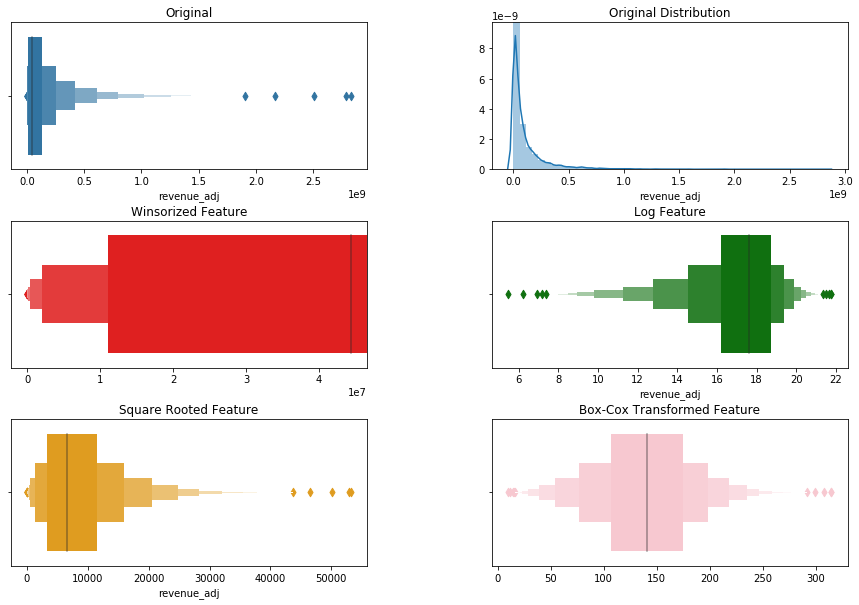

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches


 Outlier Visualization for vc_pop feature. 









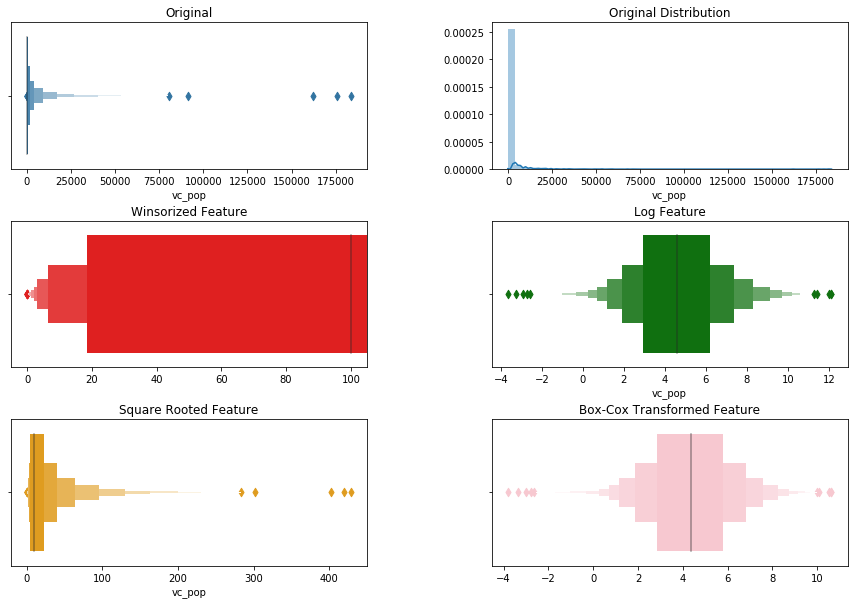

budget_adj Data isn't positive.

 Outlier Visualization for budget_adj feature. 



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

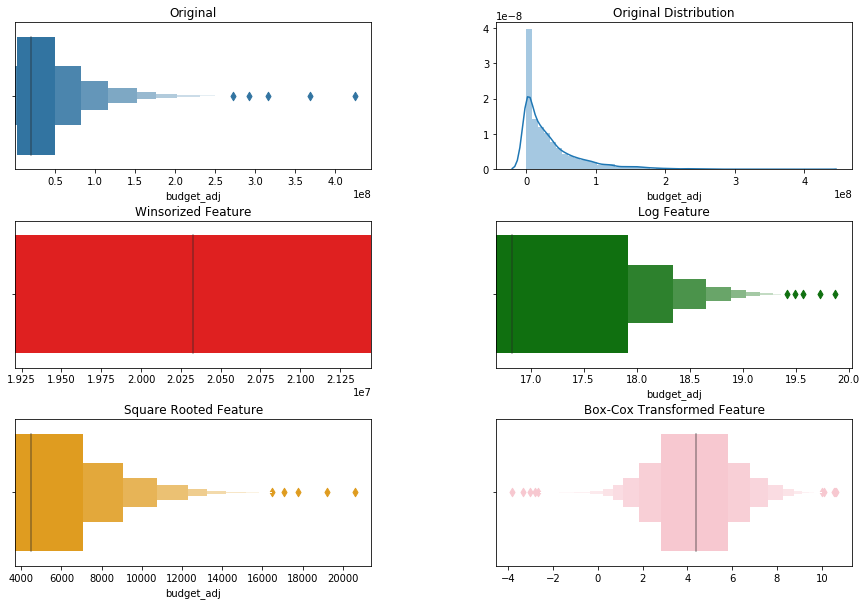

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches


 Outlier Visualization for runtime feature. 









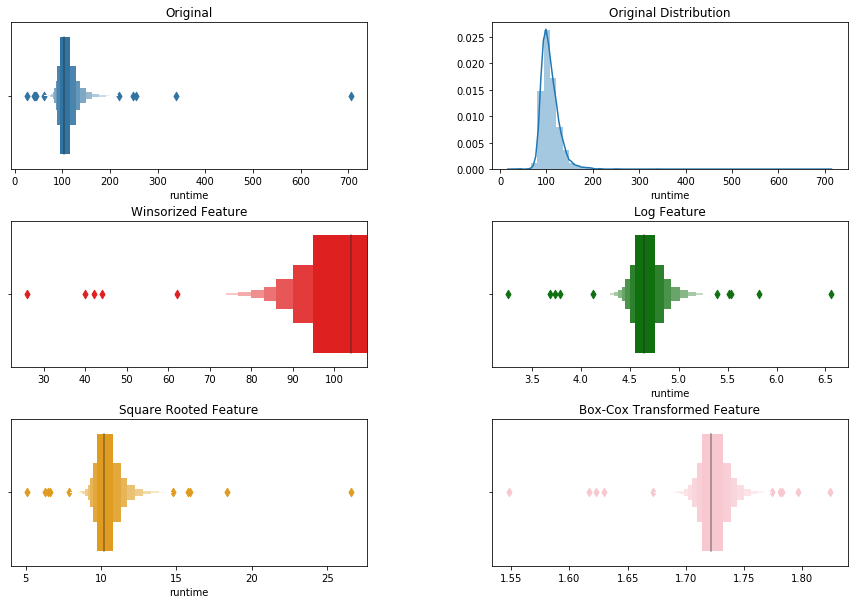

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches


 Outlier Visualization for vote_average feature. 









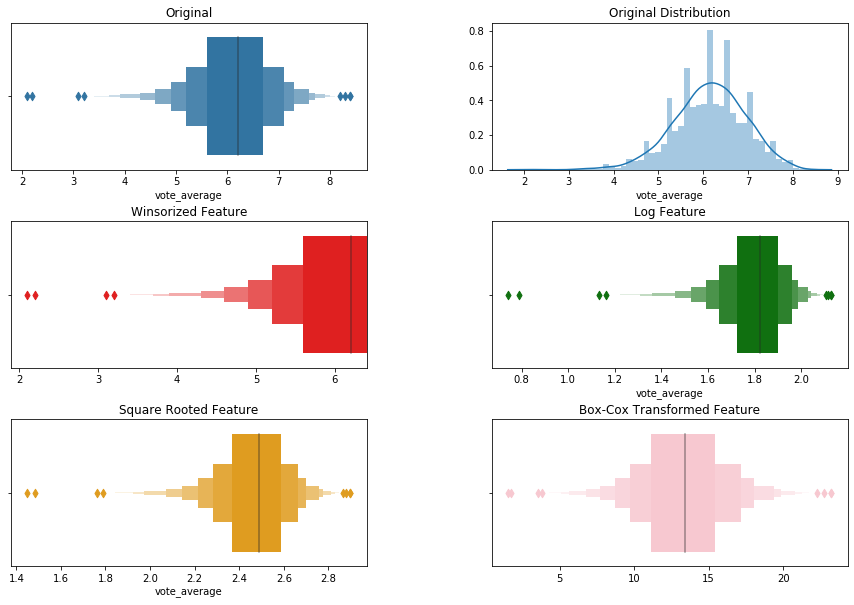

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

top_100_actors Data isn't positive.

 Outlier Visualization for top_100_actors feature. 









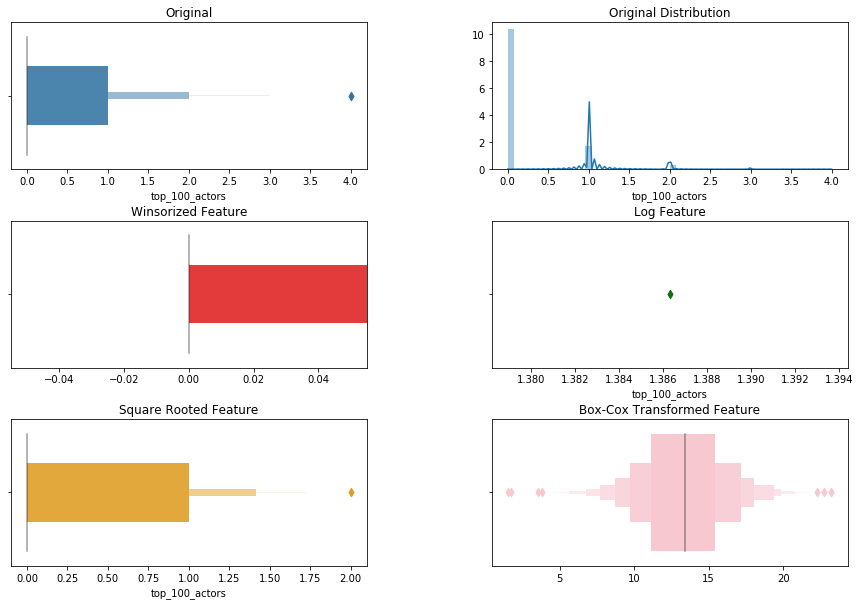

In [25]:
# Specify a list with features we want to test for normality. 
# Visuals for outliers and normality
features_to_test = ['revenue_adj','vc_pop', 'budget_adj', 'runtime', 'vote_average', 'top_100_actors']

for feat in features_to_test:
    winsorized_feature = winsorize(movies[feat], (0, 0.10))
    log_feature = np.log(movies[feat])
    sqrt_feature = np.sqrt(movies[feat])
    try:
        bc_feature,_ = stats.boxcox(movies[feat])#power_transform(np.array(fifa["Wage"]).reshape(1,-1)).reshape(-1,1)
    except ValueError: 
        print(feat, 'Data isn\'t positive.')
    
    print('\n Outlier Visualization for', feat, 'feature. \n')
    plt.figure(figsize = (15,10))
    plt.subplot(3, 2, 1)
    sns.boxenplot(x=feat, data=movies)
    plt.title('Original')
    print('\n')
    plt.subplot(3, 2, 2)
    sns.distplot(movies[feat])
    plt.title('Original Distribution')
    print('\n')
    plt.subplot(3, 2, 3)
    sns.boxenplot(winsorized_feature, color='red')
    plt.title('Winsorized Feature')
    plt.subplot(3, 2, 4)
    sns.boxenplot(log_feature, color='green')
    plt.title('Log Feature')
    print('\n')
    plt.subplot(3, 2, 5)
    sns.boxenplot(sqrt_feature, color='orange')
    plt.title('Square Rooted Feature')
    plt.subplot(3, 2, 6)
    sns.boxenplot(bc_feature, color='pink')
    plt.title('Box-Cox Transformed Feature')
    plt.subplots_adjust(hspace=0.35, wspace=0.35)
    plt.show()

## Update Variable Values

Updating the outliers in budget_adj and runtime that warranted further investigation.

In [26]:
# The budget_adj for The Warrior's way appears to have an extra 0 - multiple sources have the budget at $42 million
movies.loc[2244, 'budget_adj'] = 42500000

# Band of Brothers and Carlos are miniseries which accounts for their lengthy runtimes.
# We're only interested in movies, so I'll remove them from the dataset.
movies = movies[movies.runtime < 338]

movies.sort_values(by='vote_average', ascending=False)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Science Fiction,Documentary,Crime,Comedy,War,Western,TV Movie,Family,Romance,Music,Fantasy,Drama,Adventure,Mystery,Thriller,Action,History,Animation,Horror,Foreign,top_100_actors,tagline_length,homepage_dummy,vc_pop
7948,24128,tt0088178,0.283,1200000,4978922,Stop Making Sense,"[David Byrne, Tina Weymouth, Chris Frantz, Jer...",NaN,Jonathan Demme,Why stop making sense? Why a movie? Why a big ...,concert,David Byrne walks onto the stage and does a so...,88,Documentary|Music,Talking Heads|Arnold Stiefel Company,11/16/1984,23,8.400,1984,2518850.447,10450966.590,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,24.000,0,6.513
4178,278,tt0111161,7.192,25000000,28341469,The Shawshank Redemption,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",NaN,Frank Darabont,Fear can hold you prisoner. Hope can set you f...,prison|corruption|police brutality|prison cell...,Framed in the 1940s for the double murder of h...,142,Drama|Crime,Castle Rock Entertainment,9/10/1994,5754,8.400,1994,36777789.040,41693462.720,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,10.000,0,41382.992
7269,238,tt0068646,5.738,6000000,245066411,The Godfather,"[Marlon Brando, Al Pacino, James Caan, Richard...",http://www.thegodfather.com/,Francis Ford Coppola,An offer you can't refuse.,italy|love at first sight|loss of father|patri...,"Spanning the years 1945 to 1955, a chronicle o...",175,Drama|Crime,Paramount Pictures|Alfran Productions,3/15/1972,3970,8.300,1972,31287365.590,1277913732.000,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,5.000,1,22779.995
650,244786,tt2582802,4.780,3300000,13993093,Whiplash,"[Miles Teller, J.K. Simmons, Melissa Benoist, ...",http://sonyclassics.com/whiplash/,Damien Chazelle,The road to greatness can take you to the edge.,jazz|obsession|conservatory|music teacher|new ...,"Under the direction of a ruthless instructor, ...",105,Drama|Music,Bold Films|Blumhouse Productions|Right of Way ...,10/10/2014,2372,8.200,2014,3039600.468,12888912.730,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,10.000,1,11339.154
2875,155,tt0468569,8.467,185000000,1001921825,The Dark Knight,"[Christian Bale, Michael Caine, Heath Ledger, ...",http://thedarkknight.warnerbros.com/dvdsite/,Christopher Nolan,Why So Serious?,dc comics|crime fighter|secret identity|scarec...,Batman raises the stakes in his war on crime. ...,152,Drama|Action|Crime|Thriller,DC Comics|Legendary Pictures|Warner Bros.|Syncopy,7/16/2008,8432,8.100,2008,187365527.300,1014733032.000,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,3.000,1,71390.945
2409,550,tt0137523,8.948,63000000,100853753,Fight Club,"[Edward Norton, Brad Pitt, Meat Loaf, Jared Le...",http://www.foxmovies.com/movies/fight-club,David Fincher,How much can you know about yourself if you've...,support group|dual identity|nihilism|rage and ...,A ticking-time-bomb insomniac and a slippery s...,139,Drama,Regency Enterprises|Fox 2000 Pictures|Taurus F...,10/14/1999,5923,8.100,1999,82470329.340,132022892.500,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,14.000,1,52998.441
2389,55244,tt1621444,0.052,0,1339650,Bill Cunningham New York,"[Bill Cunningham, Tom Wolfe, Anna Wintour, Car...",http://billcunninghamnewyork.com/,Richard Press,"He who seeks beauty, will find it.",fashion|milliner|new york city ballet|poncho|g...,Chronicles a man who is obsessively interested...,84,Documentary,First Thought Films,3/24/2010,16,8.100,2010,0.000,1339650.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.000,1,0.837
10222,424,tt0108052,2.377,22000000,321265768,Schindler's List,"[Liam Neeson, Ben Kingsley, Ralph Fiennes, Car...",http://www.schindlerslist.com/,Steven Spielberg,"Whoever saves one life, saves the world entire.",factory|concentration camp|hero|holocaust|worl...,The true story of how businessman Oskar Schind...,195,Drama|History|War,Universal Pictures|Amblin Entertainment

## Normalizing the Features

The t-tests for the tranformed variables are closer to normal.

In [27]:
movies["norm_winsorized_revenue_adj"] = normalize(np.array(winsorize(movies['revenue_adj'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_vc_pop"] = normalize(np.array(winsorize(movies['vc_pop'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_sqrt_budget_adj"] = normalize(np.array(np.sqrt(movies['budget_adj'])).reshape(1,-1).reshape(-1,1))
movies["norm_winsorized_runtime"] = normalize(np.array(winsorize(movies['runtime'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_vote_average"] = normalize(np.array(winsorize(movies['vote_average'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_100_actors"] = normalize(np.array(winsorize(movies['top_100_actors'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)


In [28]:
# Testing for Normality
features_to_test = ['norm_winsorized_revenue_adj', 'norm_winsorized_vc_pop', 'norm_sqrt_budget_adj',
                    'norm_winsorized_runtime', 'norm_winsorized_vote_average', 'norm_winsorized_100_actors']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on norm_winsorized_revenue_adj:
Jarque-Bera test statistics for norm_winsorized_revenue_adj is 1116.6733274693083 and p value is 0.0
Normality test statistics for norm_winsorized_revenue_adj is 729.4458233383638 and p value is 4.007301679221774e-159

Testing for normality on norm_winsorized_vc_pop:
Jarque-Bera test statistics for norm_winsorized_vc_pop is 2546.0527042398335 and p value is 0.0
Normality test statistics for norm_winsorized_vc_pop is 1280.4462714745857 and p value is 9.007929167208106e-279

Testing for normality on norm_sqrt_budget_adj:
Jarque-Bera test statistics for norm_sqrt_budget_adj is 1725.417596065661 and p value is 0.0
Normality test statistics for norm_sqrt_budget_adj is 981.5058883660686 and p value is 7.3910197627379965e-214

Testing for normality on norm_winsorized_runtime:
Jarque-Bera test statistics for norm_winsorized_runtime is 73.27511902214522 and p value is 1.1102230246251565e-16
Normality test statistics for norm_winsorized_runti

In [29]:
movies.corr().loc[:, ["norm_winsorized_revenue_adj"]].sort_values(by='norm_winsorized_revenue_adj', ascending=False)


,norm_winsorized_revenue_adj
norm_winsorized_revenue_adj,1.000
revenue_adj,0.808
revenue,0.759
budget_adj,0.657
norm_winsorized_vc_pop,0.640
budget,0.607
vote_count,0.582
popularity,0.497
vc_pop,0.326
runtime,0.300


## Plotting the Transformed Variables

I attempted to plot the transformed variables but my kernel kept dying.

In [30]:
# Visualizing the new features. 

# features_to_test = ['norm_winsorized_revenue_adj', 'norm_winsorized_vc_pop', 'norm_sqrt_budget_adj',
#                     'norm_winsorized_runtime', 'norm_winsorized_vote_average', 'norm_winsorized_100_actors']

# for feat in features_to_test:
#     print('\n Outlier Visualization for', feat, 'feature. \n')
#     plt.figure(figsize = (15,10))
#     plt.subplot(2, 2, 1)
#     sns.boxenplot(x=feat, data=movies)
#     plt.title('New Boxenplot for ', feat)
#     print('\n')
#     plt.subplot(2, 2, 2)
#     sns.distplot(movies[feat])
#     plt.title('Distribution')
#     plt.show()

## The Cleaned and Transformed Data

A look at the data after it's been cleaned and transformed.

In [31]:
print(movies.describe())

              id  popularity        budget        revenue  runtime  \
count   4845.000    4845.000      4845.000       4845.000 4845.000   
mean   44480.637       1.046  29596501.140   89286753.677  107.823   
std    72237.599       1.357  40525081.586  162131011.345   18.965   
min        5.000       0.001         0.000          2.000   26.000   
25%     8279.000       0.388   1746964.000    7770731.000   95.000   
50%    12151.000       0.681  15000000.000   31899000.000  104.000   
75%    43947.000       1.211  40000000.000   99965753.000  117.000   
max   417859.000      32.986 425000000.000 2781505847.000  254.000   

       vote_count  vote_average  release_year    budget_adj    revenue_adj  \
count    4845.000      4845.000      4845.000      4845.000       4845.000   
mean      436.585         6.148      2000.915  35114640.514  115527954.391   
std       806.742         0.799        11.572  43407143.801  198865194.898   
min        10.000         2.100      1960.000         0.0

# Running the Models

All cross validation models will be run with ten folds and all models using training and testing sets will use a 70/30 split unless otherwise specified. Each round of models will test a new set of features. I'll use mean squared error as the evaluation metric to compare the models.

# The first Round

For our first run, I'll use all features that have correlations of greater than 0.2 with the target variable, revenue_adj.

In [32]:
linear_features1 = movies[['norm_winsorized_vc_pop', 'norm_sqrt_budget_adj', 'norm_winsorized_runtime','Adventure', 'norm_winsorized_100_actors', 'norm_winsorized_vote_average']]
linear_target = movies['norm_winsorized_revenue_adj'] ## for Linear Regression Models
linear_X_train, linear_X_test, linear_Y_train, linear_Y_test = train_test_split(linear_features1, linear_target,
                test_size = .3, random_state = 465) ## for OLS


features1 = movies[['vc_pop', 'budget_adj', 'runtime','Adventure', 'top_100_actors', 'vote_average']]
target1 = movies['revenue_adj']
X_train, X_test, Y_train, Y_test = train_test_split(features1, target1, test_size = .3, random_state = 465)


## OLS with Training & Testing Sets

All of our evaluation metrics are fairly low - in particular, the mean squared error is 0.00005949. Additionally, this model gives R-squared adjusted values of 0.482 for the training set and 0.485 for the testing set.


In [64]:
print("The number of observations in training set is {}".format(linear_X_train.shape[0]))
print("The number of observations in test set is {}".format(linear_X_test.shape[0]))

# We fit an OLS model using sklearn
linear_X_train_const = sm.add_constant(linear_X_train)
linear_X_test_const = sm.add_constant(linear_X_test)
ols = LinearRegression().fit(linear_X_train_const, linear_Y_train)

results_train = sm.OLS(linear_Y_train, linear_X_train_const).fit()
results_test = sm.OLS(linear_Y_test, linear_X_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y_preds_train = ols.predict(linear_X_train_const)
Y_preds_test = ols.predict(linear_X_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(linear_X_train_const, linear_Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(linear_X_test_const, linear_Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y_test - Y_preds_test) / linear_Y_test)) * 100))

The number of observations in training set is 3391
The number of observations in test set is 1454
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.483
Model:                                     OLS   Adj. R-squared:                  0.482
Method:                          Least Squares   F-statistic:                     526.4
Date:                         Wed, 18 Dec 2019   Prob (F-statistic):               0.00
Time:                                 10:22:35   Log-Likelihood:                 11660.
No. Observations:                         3391   AIC:                        -2.331e+04
Df Residuals:                             3384   BIC:                        -2.326e+04
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                      

## OLS With Cross Validation

The evaluation metrics are similar to the OLS with training & testing sets with an R-squared of 0.469 and MSE of 0.00006199.

In [65]:
cross_val_scores = cross_val_score(LinearRegression(), linear_features1, linear_target, cv=10)
print('OLS R-Squared Score: ', cross_val_scores.mean())
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n')

nmse_cross_val_scores = cross_val_score(LinearRegression(), linear_features1, linear_target, cv=10, scoring='neg_mean_squared_error')
print('OLS Negative MSE Score: ', nmse_cross_val_scores.mean())
print('Negative MSE Scores with Cross Validation: ', nmse_cross_val_scores)


OLS R-Squared Score:  0.4685899422730646
R-Squared Scores with Cross Validation:  [0.38839928 0.56310556 0.60339832 0.57863205 0.51309728 0.56351088
 0.54480404 0.35125644 0.35165084 0.22804475]


OLS Negative MSE Score:  -6.19972397584981e-05
Negative MSE Scores with Cross Validation:  [-8.18688257e-05 -5.04021860e-05 -4.40337793e-05 -5.10697349e-05
 -5.88012830e-05 -3.76812218e-05 -4.88055729e-05 -7.53174744e-05
 -7.09114195e-05 -1.01080900e-04]


## Lasso Model with Training & Testing Sets

The Lasso model fairs more poorly than the OLS model with an mse of 0.0001092 and an exceptionally terrible R-squared of 0.051.

In [67]:
print("The number of observations in training set is {}".format(linear_X_train.shape[0]))
print("The number of observations in test set is {}".format(linear_X_test.shape[0]))
print('\n')

lassoregr = Lasso(alpha=0.001)
 
lassoregr.fit(linear_X_train, linear_Y_train)

# We are making predictions here
Y_preds_train = lassoregr.predict(linear_X_train)
Y_preds_test = lassoregr.predict(linear_X_test)

print('Lasso Testing & Training Sets Outcomes:')
print("R-squared of the model on the training set is: {}".format(lassoregr.score(linear_X_train, linear_Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(linear_X_test, linear_Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y_test - Y_preds_test) / linear_Y_test)) * 100))

The number of observations in training set is 3391
The number of observations in test set is 1454


Lasso Testing & Training Sets Outcomes:
R-squared of the model on the training set is: 0.04894332543124846
-----Test set statistics-----
R-squared of the model on the test set is: 0.05168904426730747
Mean absolute error of the prediction is: 0.008500544185387229
Mean squared error of the prediction is: 0.0001092092956535774
Root mean squared error of the prediction is: 0.010450325145830507
Mean absolute percentage error of the prediction is: 27896.109584284302


## Lasso Regression Model with Cross Validation

The Lasso performs much better with cross validation resulting in 0.000060116 for the MSE an R-squared of 0.482 for the model. 

Using parameters obtained from GridSearchCV greatly improved the performance of the model, increasing the R-squared of the test set to 0.479 using parameters from GridSearchCV.

In [68]:
# Using GridSearchCV to find the best parameters for the Lasso Model.
lasso_gsc = GridSearchCV(
        estimator=LassoCV(),
        param_grid={
            'eps': [0.0001, 0.001, 0.1, 1]},
#             'n_alphas': [0, 1, 10]},
        cv=10, scoring='r2', verbose=1, n_jobs=-1)

grid_result = lasso_gsc.fit(linear_features1, linear_target)
best_params = grid_result.best_params_
# svr_gsc.best_estimator_
best_lasso = LassoCV(eps=best_params['eps'], verbose=False)
# n_alphas=best_params['n_alphas'],
print('Parameters for the best Lasso model: ', best_lasso)



Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Parameters for the best Lasso model:  LassoCV(alphas=None, copy_X=True, cv=None, eps=0.0001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.7s finished


In [69]:
print('Lasso Regression with Cross Validation:')
lassoregrCV = LassoCV(alphas=None, copy_X=True, cv=None, eps=0.0001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

lassoregrCV.fit(linear_features1, linear_target)

# We are making predictions here
Y_preds = lassoregrCV.predict(linear_features1)


print('Lasso Cross Validation Outcomes:')
print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(lassoregrCV.score(linear_features1, linear_target)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target - Y_preds) / linear_target)) * 100))

Lasso Regression with Cross Validation:
Lasso Cross Validation Outcomes:
-----Test set statistics-----
R-squared of the model is: 0.48286678658854215
Mean absolute error of the prediction is: 0.00566493709158281
Mean squared error of the prediction is: 6.011611696528559e-05
Root mean squared error of the prediction is: 0.007753458387409169
Mean absolute percentage error of the prediction is: 19709.36547679557


## Ridge Regression with Training &Testing Sets

The Ridge model performs similiarly to the previous models with an mse of 0.000061825, so I will continue to test with it as we change our features.

In [71]:
ridgeregr = Ridge(alpha=0) 
ridgeregr.fit(linear_X_train, linear_Y_train)

# We are making predictions here
Y_preds_train = ridgeregr.predict(linear_X_train)
Y_preds_test = ridgeregr.predict(linear_X_test)

print('Ridge Testing & Training Sets Outcomes:')
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(linear_X_train, linear_Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(linear_X_test, linear_Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(linear_Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y_test - Y_preds_test) / linear_Y_test)) * 100))

Ridge Testing & Training Sets Outcomes:
R-squared of the model on the training set is: 0.4827472132968406
-----Test set statistics-----
R-squared of the model on the test set is: 0.48334548291405244
Mean absolute error of the prediction is: 0.005613189857002902
Mean squared error of the prediction is: 5.949891811974385e-05
Root mean squared error of the prediction is: 0.007713554182070924
Mean absolute percentage error of the prediction is: 9263.57100159789


## Ridge Regression with Cross Validation

The Ridge model with cross validation results in evaluation metrics extremely similar to the model with training and testing sets.


In [72]:
ridgeCV = RidgeCV(alphas=(0.001, 0.01, .1, 1, 10), cv=10)
ridgeCV.fit(linear_features1, linear_target)

# We are making predictions here
Y_preds = ridgeCV.predict(linear_features1)

print('Ridge Cross Validation Outcomes:')
print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(ridgeCV.score(linear_features1, linear_target)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target - Y_preds) / linear_target)) * 100))

Ridge Cross Validation Outcomes:
-----Test set statistics-----
R-squared of the model is: 0.4832708585864131
Mean absolute error of the prediction is: 0.005655454381286802
Mean squared error of the prediction is: 6.006914407927397e-05
Root mean squared error of the prediction is: 0.007750428638422134
Mean absolute percentage error of the prediction is: 19539.749528150653


## ElasticNet Regression Model with Training & Testing Sets

The ElasticNet performs virtually exactly the same as the Lasso and Ridge models.

In [73]:
elasticregr = ElasticNet(l1_ratio=1000, alpha=0) 
elasticregr.fit(linear_X_train, linear_Y_train)

# We are making predictions here
Y_preds_train = elasticregr.predict(linear_X_train)
Y_preds_test = elasticregr.predict(linear_X_test)

print('ElasticNet Training & Testing Sets Outcomes:')
print("R-squared of the model on the training set is: {}".format(elasticregr.score(linear_X_train, linear_Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(linear_X_test, linear_Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y_test - Y_preds_test) / linear_Y_test)) * 100))

ElasticNet Training & Testing Sets Outcomes:
R-squared of the model on the training set is: 0.4827472132968406
-----Test set statistics-----
R-squared of the model on the test set is: 0.4833454829140524
Mean absolute error of the prediction is: 0.005613189857002899
Mean squared error of the prediction is: 5.9498918119743865e-05
Root mean squared error of the prediction is: 0.007713554182070925
Mean absolute percentage error of the prediction is: 9263.57100159785


## ElasticNet Regression Model with Cross Validation

This model performs terribly under cross validation, so though it has a very small MSE, I will likely drop it from the analysis.

In [84]:
elasticregrCV = ElasticNetCV(l1_ratio=.001, n_alphas=10, cv=5) 
elasticregrCV.fit(linear_features1, linear_target)

# We are making predictions here
Y_preds = elasticregrCV.predict(linear_features1)

print('ElasticNet Cross Validation Outcomes:')
print("R-squared of the model on the training set is: {}".format(elasticregrCV.score(linear_features1, linear_target)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(linear_features1, linear_target)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target - Y_preds) / linear_target)) * 100))

ElasticNet Cross Validation Outcomes:
R-squared of the model on the training set is: 0.21484806787789745
-----Test set statistics-----
R-squared of the model on the test set is: 0.21484806787789745
Mean absolute error of the prediction is: 0.007523320200375182
Mean squared error of the prediction is: 9.127297215276195e-05
Root mean squared error of the prediction is: 0.009553688929034793
Mean absolute percentage error of the prediction is: 25767.87645541604


In [43]:
# Using GridSearchCV to find the best parameters for the ElasticNEt
en_gsc = GridSearchCV(
        estimator=ElasticNetCV(),
        param_grid={'l1_ratio': [0.1, 0.3, 0.7, 1]}, verbose=1)
#                     ,
grid_result = en_gsc.fit(features1, target)
best_params = grid_result.best_params_
best_en = ElasticNetCV(l1_ratio=best_params['l1_ratio'])

print('Parameters for the best ElasticNet Model: ', best_en)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Parameters for the best ElasticNet Model:  ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished


## Random Forests Ensemble with Training & Testing Sets
With an R-squared score of 0.935 on the training set and 0.559 on the test set, we can see that while this model accounts for 56% of the variance. This is a fine start, but we should be able to improve it by using new features.

Using GridSearchCV improved the performance of the model slightly, increasing the range of scores from 0.22 to 0.73 and the average to 0.60.

In [87]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
rfr.fit(X_train, Y_train)

Y_preds_train = rfr.predict(X_train)
Y_preds_test = rfr.predict(X_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.9352751526162139
-----Test set statistics-----
R-squared of the model on the test set is: 0.5101005518276293
Mean absolute error of the prediction is: 68895470.5654846
Mean squared error of the prediction is: 1.6727188971874368e+16
Root mean squared error of the prediction is: 129333634.34108843
Mean absolute percentage error of the prediction is: 7511.64814595948


## Random Forests Ensemble with Cross Validation
With R-squared scores ranging from 0.134 to 0.695 and an average of 0.541, we can see that while this model accounts for nearly 54% of the variance. This is fine start, but I should be able to improve it by using new features.

Using GridSearchCV improved the performance of the model slightly, increasing the range of scores from 0.144 to 0.743 and the average to 0.584. The mean squared error is very high.

In [34]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)

cross_val_scores = cross_val_score(rfr, features1, target1, cv=10)
nmse_cross_val_scores = cross_val_score(rfr, features1, target1, cv=10, verbose=1, scoring='neg_mean_squared_error')

print('Mean R-Squared: ', cross_val_scores.mean())
print('R-Squared Scores with Cross Validation: ', cross_val_scores)

print('\n')
print('Negative Mean MSE: ', nmse_cross_val_scores.mean())
print('Negative MSE Scores with Cross Validation: ', nmse_cross_val_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.5387426931671362
R-Squared Scores with Cross Validation:  [0.49638864 0.50067828 0.70885573 0.67968021 0.60665289 0.68523533
 0.61408421 0.48269135 0.49023392 0.12292637]


Negative Mean MSE:  -1.926656163012431e+16
Negative MSE Scores with Cross Validation:  [-4.05914583e+16 -1.33074397e+16 -8.80086755e+15 -1.29193675e+16
 -1.67885270e+16 -6.80395589e+15 -1.27730868e+16 -1.57915033e+16
 -1.24718152e+16 -5.24175952e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   27.0s finished


Using GridSearchCV to find the best parameters for the Random Forests.

In [36]:
rf_gsc = GridSearchCV(
        estimator=ensemble.RandomForestRegressor(),
        param_grid={
            'max_depth': [80, 90, 100],
            'max_features': [2, 3],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [100, 500, 1000]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

rf_gsc.fit(features1, target1)
best_params = rf_gsc.best_params_
# svr_gsc.best_estimator_
best_rf = ensemble.RandomForestRegressor(max_depth=best_params['max_depth'], max_features=best_params["max_features"],
                                         min_samples_leaf=best_params["min_samples_leaf"], min_samples_split=best_params["min_samples_split"],
                                         n_estimators=best_params['n_estimators'],verbose=False)

print('Parameters for the best Support Vector Model: ', best_rf)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 20.2min finished


Parameters for the best Support Vector Model:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)


In [40]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)
cross_val_scores = cross_val_score(rfr, features1, target1, cv=10, verbose=1)
nmse_cross_val_scores = cross_val_score(rfr, features1, target1, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('R-Squared Scores with Cross Validation: ', cross_val_scores)

print('\n')
print('Mean MSE: ', nmse_cross_val_scores.mean())
print('MSE Scores with Cross Validation: ', nmse_cross_val_scores)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   42.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.5831479886187184
R-Squared Scores with Cross Validation:  [0.54105608 0.6198894  0.7457066  0.73360084 0.62258053 0.72329989
 0.68242805 0.52490217 0.49478682 0.14322951]


Mean MSE:  -1.7758286087002358e+16
MSE Scores with Cross Validation:  [-3.67566851e+16 -1.05272500e+16 -7.74401273e+15 -1.06288692e+16
 -1.60145735e+16 -6.19246388e+15 -1.05087822e+16 -1.44642889e+16
 -1.30357865e+16 -5.17101489e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   43.0s finished


## Support Vector Machines with Testing & Training Sets

This is by far the worst model with an R-squared of -0.145 and a huge MSE.

In [42]:
svr = SVR()
svr.fit(X_train, Y_train)

Y_preds_train = svr.predict(X_train)
Y_preds_test = svr.predict(X_test)


print("R-squared of the model on the training set is: {}".format(svr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(svr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: -0.12269439344843369
-----Test set statistics-----
R-squared of the model on the test set is: -0.1289560907884708
Mean absolute error of the prediction is: 97576045.47390132
Mean squared error of the prediction is: 3.854722013265647e+16
Root mean squared error of the prediction is: 196334459.87053946
Mean absolute percentage error of the prediction is: 15701.138058005305


## Support Vector Machines with Cross Validation

This is by far the worst model with an MSE of 4.462e+16. While it's actually a fairly precise model with scores from -0.210 to -0.079, these scores are still very bad and average to -0.128. My guess is that SVR is simply a poor model for this data. However, the negative mean squared errors are the smallest seen so far.

Utilizing GridSearchCV for the best parameters had virtually no affect on the performance of the model. I will likely proceed without support vector machines.

In [45]:
svr = SVR()
svr.fit(features1, target1)
print('\n SVR R-Squared Score: ', svr.score(features1, target1))
print('\n SVR R-Squared Scores with Cross Validation: ', cross_val_score(svr, features1, target1, cv=10, scoring='r2'))
nmse_cross_val_score = cross_val_score(svr, features1, target1, cv=10, scoring='neg_mean_squared_error')
print('\n SVR Mean Squared Error Scores with Cross Validation: ', nmse_cross_val_score)
print('\n SVR Mean Negative MSE Score with Cross Validation: ', nmse_cross_val_score.mean())


 SVR R-Squared Score:  -0.12820469171623894

 SVR R-Squared Scores with Cross Validation:  [-0.09569447 -0.11394396 -0.16267225 -0.11838901 -0.11331719 -0.07890586
 -0.12470614 -0.21136659 -0.15339993 -0.20191639]

 SVR Mean Squared Error Scores with Cross Validation:  [-8.73671846e+16 -3.07428121e+16 -3.53006344e+16 -4.49957107e+16
 -4.75022836e+16 -2.43325775e+16 -3.71379672e+16 -3.68734644e+16
 -2.96747066e+16 -7.22920950e+16]

 SVR Mean Negative MSE Score with Cross Validation:  -4.462194361408655e+16


Using GridSearchCV to find the best parameters for the support vectors

In [46]:
svr_gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 200],
            'epsilon': [0.0001, .001, 0.1],
            'gamma': [0.0001, 0.001, 0.01, 0.1]
        },
        cv=10, verbose=1, n_jobs=-1)

In [48]:
svr_gsc.fit(features1, target1)
best_params = svr_gsc.best_params_
# svr_gsc.best_estimator_
best_svr = SVR(kernel='rbf', C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)

print('Parameters for the best Support Vector Model: ', best_svr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.9min finished


Parameters for the best Support Vector Model:  SVR(C=200, cache_size=200, coef0=0.1, degree=3, epsilon=0.0001, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [52]:
svr = SVR(C=200, cache_size=200, coef0=0.1, degree=3, epsilon=0.0001, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(features1, target1)
print('\n SVR Score: ', svr.score(features1, target1))
print('SVR R-Squared Scores with Cross Validation: ', cross_val_score(svr, features1, target1, cv=10, scoring='r2'))
nmse_cross_val_score = cross_val_score(svr, features1, target1, cv=10, scoring='neg_mean_squared_error')
print('\n SVR Mean Negative MSE Score with Cross Validation: ', nmse_cross_val_score.mean())
print('\n SVR Negative MSE Scores with Cross Validation: ', nmse_cross_val_score)


 SVR Score:  -0.12816844301758779
SVR R-Squared Scores with Cross Validation:  [-0.09565831 -0.11387085 -0.16265426 -0.11837326 -0.11329329 -0.07886378
 -0.12469808 -0.21136765 -0.1533882  -0.20187215]

 SVR Mean Negative MSE Score with Cross Validation:  -4.4620818999733224e+16

 SVR Negative MSE Scores with Cross Validation:  [-8.73643011e+16 -3.07407944e+16 -3.53000883e+16 -4.49950771e+16
 -4.75012638e+16 -2.43316285e+16 -3.71377013e+16 -3.68734965e+16
 -2.96744051e+16 -7.22894339e+16]


## Gradient Boosting Regressor with Training & Testing Sets

The R-squared for the training set is high at 0.887 but the value for the test set is 0.516, indicating there is quite a bit of overfitting. The mean squared error is very high at 1.677e+16. Using the parameters obtained with GridSearchCV slightly increases the performance of the model.

In [55]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=3, loss='ls')

gbr.fit(X_train, Y_train)

Y_preds_train = gbr.predict(X_train)
Y_preds_test = gbr.predict(X_test)


print("R-squared of the model on the training set is: {}".format(gbr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.8800139202150324
-----Test set statistics-----
R-squared of the model on the test set is: 0.508746798190333
Mean absolute error of the prediction is: 66303580.49751641
Mean squared error of the prediction is: 1.6773411707982554e+16
Root mean squared error of the prediction is: 129512206.79141621
Mean absolute percentage error of the prediction is: 6487.584609594364


In [56]:
# Using GridSearchCV to find the best parameters for the Gradient Boosting
gbr_gsc = GridSearchCV(
        estimator= ensemble.GradientBoostingRegressor(loss='ls'),
        param_grid={
            'learning_rate': [0.01, 0.1, 1],
            'n_estimators': [100, 500]},
        cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gbr_gsc.fit(features1, target1)
best_params = grid_result.best_params_
best_gbr = ensemble.GradientBoostingRegressor(learning_rate=best_params['learning_rate'], 
                        n_estimators=best_params['n_estimators'], tol=0.001)

print(best_gbr)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [57]:
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

gbr.fit(X_train, Y_train)

Y_preds_train = gbr.predict(X_train)
Y_preds_test = gbr.predict(X_test)


print("R-squared of the model on the training set is: {}".format(gbr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.7034812767703122
-----Test set statistics-----
R-squared of the model on the test set is: 0.5720590888327717
Mean absolute error of the prediction is: 64132057.78133097
Mean squared error of the prediction is: 1.461166881611123e+16
Root mean squared error of the prediction is: 120878735.9964987
Root mean squared error of the prediction is: 120878735.9964987
Mean absolute percentage error of the prediction is: 7462.389817154665


## Gradient Boosting with Cross Validation

This model has the highest performace with an R-squared of 0.673, though the MSE is still very large. 

In [59]:
gbr.fit(features1, target1)
print('\n SVR R-Squared Score: ', gbr.score(features1, target1))
print('\n SVR R-Squared Scores with Cross Validation: ', cross_val_score(gbr, features1, target1, cv=10, scoring='r2'))
nmse_cross_val_score = cross_val_score(gbr, features1, target1, cv=10, scoring='neg_mean_squared_error')
print('\n SVR Mean Squared Error Scores with Cross Validation: ', nmse_cross_val_score)
print('\n SVR Mean Negative MSE Score with Cross Validation: ', nmse_cross_val_score.mean())


 SVR R-Squared Score:  0.6726183833381758

 SVR R-Squared Scores with Cross Validation:  [0.51943438 0.52132693 0.71990634 0.7200218  0.67323543 0.72418677
 0.6682583  0.48234809 0.44340518 0.11207807]

 SVR Mean Squared Error Scores with Cross Validation:  [-3.83066670e+16 -1.31894284e+16 -8.51075600e+15 -1.12642543e+16
 -1.40346255e+16 -6.21993455e+15 -1.09431905e+16 -1.57560989e+16
 -1.43200877e+16 -5.34180134e+16]

 SVR Mean Negative MSE Score with Cross Validation:  -1.859630562357495e+16


## Summary of First Round


|Model | R-Squared Value |Mean Squared Error| Notes
------|------|------|------|
|OLS (CV) |0.468 | 5.949e-05|
|Lasso Regression (CV) |0.482 | 6.011e-05|
|Ridge Regression (CV) |0.479 | 6.001e-05|
|ElasticNet (CV) |0.200 | 9.127e-05|
|Random Forests (CV) |0.583 | 1.926e+16|
|Support Vector Machines (CV)|-0.128|4.462e+16|
|Gradient Boosting (CV)|0.561|1.859e+16|
|XGBoost (CV)|0.492|2.1298e+16|



# Second Round

In this round, I will use all the features available to me in the data. Moving forward, I will use GridSearchCV to obtain the best parameters of each model.

In [60]:
features2 = movies[['budget_adj', 'vc_pop', 'runtime', 'Adventure', 'top_100_actors',
                    'vote_average', 'Action', 'Family', 'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction',
                    'War', 'tagline_length', 'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy',
                    'Crime', 'Music', 'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]
target2 = movies['revenue_adj']
X2_train, X2_test, Y2_train, Y2_test = train_test_split(features2, target2, test_size = .3, random_state = 465)


linear_features2 = movies[['norm_sqrt_budget_adj', 'norm_winsorized_vc_pop', 'norm_winsorized_runtime', 'Adventure', 'norm_winsorized_100_actors',
                    'norm_winsorized_vote_average', 'Action', 'Family', 'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction',
                    'War', 'tagline_length', 'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy',
                    'Crime', 'Music', 'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]
linear_target2 = movies['norm_winsorized_revenue_adj'] ## for Linear Regression Models
linear_X2_train, linear_X2_test, linear_Y2_train, linear_Y2_test = train_test_split(linear_features2, linear_target2,
                test_size = .3, random_state = 465)




## OLS with Training and Test Sets

I've decreased the MSE to 5.2004e-05 and increased the R-squareds from 0.486/0.59 to 0.565/0.551 for the training and test sets respectively. The gap between the lowest scoring fold and the highest scoring fold has closed slightly, indicating there is less overfitting. However, the AIC and BIC for both the training and test sets are slightly larger than the first OLS model we ran.


In [61]:
print("The number of observations in training set is {}".format(linear_X2_train.shape[0]))
print("The number of observations in test set is {}".format(linear_X2_test.shape[0]))

# We fit an OLS model using sklearn
linear_X2_train_const = sm.add_constant(linear_X2_train)
linear_X2_test_const = sm.add_constant(linear_X2_test)
ols = LinearRegression().fit(linear_X2_train_const, linear_Y2_train)

results_train = sm.OLS(linear_Y2_train, linear_X2_train_const).fit()
results_test = sm.OLS(linear_Y2_test, linear_X2_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y2_preds_train = ols.predict(linear_X2_train_const)
Y2_preds_test = ols.predict(linear_X2_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(linear_X2_train_const, linear_Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(linear_X2_test_const, linear_Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y2_test - Y2_preds_test) / linear_Y2_test)) * 100))

The number of observations in training set is 3391
The number of observations in test set is 1454
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.565
Model:                                     OLS   Adj. R-squared:                  0.561
Method:                          Least Squares   F-statistic:                     155.7
Date:                         Wed, 18 Dec 2019   Prob (F-statistic):               0.00
Time:                                 15:19:56   Log-Likelihood:                 11952.
No. Observations:                         3391   AIC:                        -2.385e+04
Df Residuals:                             3362   BIC:                        -2.367e+04
Df Model:                                   28                                         
Covariance Type:                     nonrobust                                         
                      

## OLS with Cross Validation

The OLS with cross validation improved 8% points increasing from 0.469 to 0.550, moving in the right direction as opposed to the Random Forests Model. The MSE continues to stay low at .00005.

In [62]:
cross_val_scores = cross_val_score(LinearRegression(), linear_features2, linear_target, cv=10)
nmse_cross_val_scores = cross_val_score(LinearRegression(), linear_features2, linear_target, cv=10, scoring='neg_mean_squared_error')
print('OLS R-Squared Score: ', cross_val_scores.mean())
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n')
print('Negative MSE Score: ', nmse_cross_val_scores.mean())
print('Negative MSE Scores with Cross Validation: ', nmse_cross_val_scores)

OLS R-Squared Score:  0.5513808437903202
R-Squared Scores with Cross Validation:  [0.5868818  0.61053151 0.66194837 0.62878998 0.60322385 0.59836755
 0.62078802 0.42248201 0.41347736 0.36731798]


Negative MSE Score:  -5.200443609808831e-05
Negative MSE Scores with Cross Validation:  [-5.52999698e-05 -4.49309073e-05 -3.75331006e-05 -4.49906008e-05
 -4.79170593e-05 -3.46721161e-05 -4.06586605e-05 -6.70483663e-05
 -6.41493123e-05 -8.28442680e-05]


## Ridge Regression with Training & Testing Sets

Both Ridge models have increased in performance with the additional features and are scoring similiarly to the OLS model. The model has an MSE of 5.2941e-05 with cross validation.

In [65]:
ridgeregr = Ridge(alpha=0.1) 
ridgeregr.fit(linear_X_train, linear_Y_train)

# We are making predictions here
Y_preds_train = ridgeregr.predict(linear_X_train)
Y_preds_test = ridgeregr.predict(linear_X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(linear_X_train, linear_Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(linear_X_test, linear_Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(linear_Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y_test - Y_preds_test) / linear_Y_test)) * 100))

R-squared of the model on the training set is: 0.467613751613978
-----Test set statistics-----
R-squared of the model on the test set is: 0.4692845403277331
Mean absolute error of the prediction is: 0.0058858252310781175
Mean squared error of the prediction is: 6.111820304605886e-05
Root mean squared error of the prediction is: 0.00781781318822974
Mean absolute percentage error of the prediction is: 10997.224399338533


## Ridge With Cross Validation

Similiar improvement as the OLS model.

In [66]:
ridgeCV = RidgeCV(alphas=(0.1, 10), cv=5)
ridgeCV.fit(linear_features2, linear_targe2)

# We are making predictions here
Y_preds = ridgeCV.predict(linear_features2)


print('Ridge Cross Validation Outcomes:')
print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(ridgeCV.score(linear_features2, linear_target2)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target2, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target2, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target2, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target2 - Y_preds) / linear_target2)) * 100))

Ridge Cross Validation Outcomes:
-----Test set statistics-----
R-squared of the model is: 0.5445897103672824
Mean absolute error of the prediction is: 0.005413955868476505
Mean squared error of the prediction is: 5.2940900968532634e-05
Root mean squared error of the prediction is: 0.007276049818997437
Mean absolute percentage error of the prediction is: 18278.868310920232


## ElasticNet With Training & Testing Sets

The ElasticNet performs much better using all the features when we use training and tesing sets. However, it produces poor scores in cross validation indicating there is much overfitting. I will drop it from the analysis.

In [67]:
# Using GridSearchCV to find the best parameters for the ElasticNEt
en_gsc = GridSearchCV(
        estimator=ElasticNetCV(),
        param_grid={'l1_ratio': [0.1, 0.3, 0.7, 1]}, verbose=1)
#                     ,
grid_result = en_gsc.fit(linear_features2, linear_target2)
best_params = grid_result.best_params_
best_en = ElasticNetCV(l1_ratio=best_params['l1_ratio'])

print('Parameters for the best ElasticNet Model: ', best_en)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Parameters for the best ElasticNet Model:  ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.2s finished


In [70]:
elasticregr = ElasticNet(l1_ratio=1, max_iter=1000)
                         
elasticregr.fit(linear_X2_train, linear_Y2_train)

# We are making predictions here
Y_preds_train = elasticregr.predict(linear_X2_train)
Y_preds_test = elasticregr.predict(linear_X2_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(linear_X2_train, linear_Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(linear_X2_test, linear_Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y2_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y2_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y2_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y2_test - Y_preds_test) / linear_Y2_test)) * 100))

R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.00019474898630789106
Mean absolute error of the prediction is: 0.008740175206901754
Mean squared error of the prediction is: 0.00011518433209369246
Root mean squared error of the prediction is: 0.010732396381689062
Mean absolute percentage error of the prediction is: 30474.531134229648


## ElasticNet with Cross Validation

This model performs better with cross validation, but still very poorly.

In [72]:
elasticregrCV = ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)
elasticregrCV.fit(linear_X2_train, linear_Y2_train)
# We are making predictions here
Y_preds = elasticregrCV.predict(linear_features2)

print('\n')
print("R-squared of the model on the training set is: {}".format(elasticregrCV.score(linear_features2, linear_target2)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(linear_features2, linear_target2)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target2, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target2, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target2, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target2 - Y_preds) / linear_target2))))



R-squared of the model on the training set is: 0.523361679681323
-----Test set statistics-----
R-squared of the model on the test set is: 0.523361679681323
Mean absolute error of the prediction is: 0.005639885918173527
Mean squared error of the prediction is: 5.540863412231954e-05
Root mean squared error of the prediction is: 0.007443697610886645
Mean absolute percentage error of the prediction is: 176.692083748148


## Random Forests

While there is much overfitting, this model performs better than in the first round with a decrease in MSE to  1.3944e+16. 

In [74]:
rf_gsc = GridSearchCV(
        estimator=ensemble.RandomForestRegressor(),
        param_grid={
            'max_depth': [80, 90, 100],
            'max_features': [2, 3],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [100, 500, 1000]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

rf_gsc.fit(features2, target2)
best_params = rf_gsc.best_params_
# svr_gsc.best_estimator_
best_rf = ensemble.RandomForestRegressor(max_depth=best_params['max_depth'], max_features=best_params["max_features"],
                                         min_samples_leaf=best_params["min_samples_leaf"], min_samples_split=best_params["min_samples_split"],
                                         n_estimators=best_params['n_estimators'],verbose=False)

print('Parameters for the best Support Vector Model: ', best_rf)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 14.7min finished


Parameters for the best Support Vector Model:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)


In [75]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)
rfr.fit(X2_train, Y2_train)

Y2_preds_train = rfr.predict(X2_train)
Y2_preds_test = rfr.predict(X2_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

R-squared of the model on the training set is: 0.716173990116335
-----Test set statistics-----
R-squared of the model on the test set is: 0.5915962228740905
Mean absolute error of the prediction is: 64107579.04044874
Mean squared error of the prediction is: 1.3944590430338086e+16
Root mean squared error of the prediction is: 118087215.3551691
Mean absolute percentage error of the prediction is: 10003.701027189563


In [76]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)

cross_val_scores = cross_val_score(rfr, features2, target2, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(rfr, features2, target2, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.6013178123310519
Cross Validation Scores:  [0.56869417 0.66737628 0.7537533  0.70848238 0.60591533 0.72917955
 0.69780937 0.52429695 0.49452671 0.26314407]


Mean Negative MSE:  -1.688545872385631e+16
Cross Validation MSE Scores:  [-3.50240238e+16 -9.12964424e+15 -7.57805723e+15 -1.16486228e+16
 -1.74941869e+16 -6.49300747e+15 -9.54303121e+15 -1.45009801e+16
 -1.29535420e+16 -4.44894917e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.1s finished


## SVR

Again, the Support Vector Machines model performs terribly with an MSE of 4.462e+16, so I will drop it from the analysis.

In [78]:
# Using GridSearchCV to find the best parameters for the support vectors
svr_ve_gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100],
            'epsilon': [0.0001, .001, 0.1,  1, 5],
            'gamma': [0.001, 0.01, 0.1, 1, 10]
        },
        cv=10, scoring='explained_variance', verbose=1, n_jobs=-1)

svr_ve_gsc.fit(features2, target2)
best_params = svr_ve_gsc.best_params_
# svr_gsc.best_estimator_
best_svr_ve = SVR(kernel='rbf', C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)

print('Parameters for the best Support Vector Model: ', best_svr)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  7.2min finished


Parameters for the best Support Vector Model:  SVR(C=200, cache_size=200, coef0=0.1, degree=3, epsilon=0.0001, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [79]:
svr = SVR(C=200, cache_size=200, coef0=0.1, degree=3, epsilon=0.0001, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(X2_train, Y2_train)

# We are making predictions here
Y2_preds_train = svr.predict(X2_train)
Y2_preds_test = svr.predict(X2_test)


print("R-squared of the model on the training set is: {}".format(svr.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(svr.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

R-squared of the model on the training set is: -0.12268747592253249
-----Test set statistics-----
R-squared of the model on the test set is: -0.12894494963609815
Mean absolute error of the prediction is: 97567689.82885522
Mean squared error of the prediction is: 3.854683972773502e+16
Root mean squared error of the prediction is: 196333491.10056344
Mean absolute percentage error of the prediction is: 15686.70084818157


In [81]:
svr = SVR(C=200, cache_size=200, coef0=0.1, degree=3, epsilon=0.0001, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr.fit(features2,target2)
print('SVR Score: ', svr.score(features2, target2))
print('R-squared scores: ', cross_val_score(svr, features2, target2, cv=10))
nmse_cross_val_scores = cross_val_score(svr, features2, target2, cv=10, scoring='neg_mean_squared_error')

print('Negative MSE Score: ', nmse_cross_val_scores.mean())
print('Negative MSE scores: ', nmse_cross_val_scores)

SVR Score:  -0.12819116449728507
R-squared scores:  [-0.0956583  -0.11387535 -0.16265453 -0.11837358 -0.11329371 -0.07886456
 -0.1246975  -0.21136747 -0.15338851 -0.20187115]
Negative MSE Score:  -4.462082932204946e+16
Negative MSE scores:  [-8.73643004e+16 -3.07409187e+16 -3.53000962e+16 -4.49950901e+16
 -4.75012819e+16 -2.43316459e+16 -3.71376822e+16 -3.68734910e+16
 -2.96744130e+16 -7.22893738e+16]


## Gradient Boosting with Training & Testing Sets

This model's performance has increased from an R-squared of 0.57 to 0.642 with the additional features and the MSE has decreased to 1.40e+16.

In [84]:
# Using GridSearchCV to find the best parameters for the Gradient Boosting
gbr_gsc = GridSearchCV(
        estimator= ensemble.GradientBoostingRegressor(loss='ls'),
        param_grid={
            'learning_rate': [0.01, 0.1, 1],
            'n_estimators': [100, 500, 1000],
            'max_depth': [3, 4, 5]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_result = gbr_gsc.fit(features2, target2)
best_params = grid_result.best_params_
best_gbr = ensemble.GradientBoostingRegressor(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], 
                    max_depth=best_params['max_depth'],  tol=0.001)

print(best_gbr)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  6.3min finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [85]:
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

gbr.fit(X2_train, Y2_train)

Y2_preds_train = gbr.predict(X2_train)
Y2_preds_test = gbr.predict(X2_test)


print("R-squared of the model on the training set is: {}".format(gbr.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y2_test, Y2_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

R-squared of the model on the training set is: 0.890013975255235
-----Test set statistics-----
R-squared of the model on the test set is: 0.6234700949417298
Mean absolute error of the prediction is: 56699084.432194225
Mean squared error of the prediction is: 1.2856284894723034e+16
Root mean squared error of the prediction is: 113385558.58098964
Root mean squared error of the prediction is: 113385558.58098964
Mean absolute percentage error of the prediction is: 4082.6144017624174


In [87]:
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

cross_val_scores = cross_val_score(gbr, features2, target2, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(gbr, features2, target2, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.662548729369702
Cross Validation Scores:  [0.66250778 0.66016207 0.77924235 0.72038353 0.7092406  0.76163635
 0.78007784 0.60298856 0.58035335 0.36889486]


Mean Negative MSE:  -1.400233089180357e+16
Cross Validation MSE Scores:  [-2.69220121e+16 -9.37493454e+15 -6.70145371e+15 -1.12451684e+16
 -1.23537913e+16 -5.35068331e+15 -7.26739870e+15 -1.20733653e+16
 -1.07331926e+16 -3.80013089e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished


## Summary of Second Round

|Model | R-Squared Value |Mean Squared Error
------|------|------|
|OLS (CV) |0.550 | 5.200e-05
|Ridge Regression (CV) |0.542 |5.294e-05
|ElasticNet (Test) |0.523 | 5.451e-05
|Random Forests (CV) |0.602 | 1.394e+16
|Support Vector Machines (CV)|-0.128| 4.462e+16
|Gradient Boosting (CV)|0.658|1.400e+16
|XGBoost (CV)|0.606| 






## New Variables

After running a few models, I'm going to create some new variables. Concerning the cast column and our new variable top_100_stars, below we can see that this new variable is not well-distributed. I'm going to pull in a list of top 1,000 actors and see if that makes a difference.

Additionally, I'll look at the top 100 Production Companies.

Finally, it could be interesting to see whether film adaptations of books fare better, so I'll pull in a list of books that have been made into films.

## New Top 1,000 Actors Feature

In [88]:
print('Number of movies for each number of stars in top_100_actors (0-5): \n', movies.top_100_actors.value_counts())

# Importing the top 1000 actors 

top_1000_actors = pd.read_csv('top_1000_actors.csv')
top_1000_actors = pd.DataFrame(top_1000_actors)


# Converting the series to a list so we can compare it to the cast lists
top_1000_actors = top_1000_actors['Name'].tolist()
print('\n Testing the list: ', top_1000_actors[:5], '\n')

movies['top_1000_actors'] = [len(set(i) & set(top_1000_actors)) for i in movies['cast']]
print('Number of movies for each number of actors in top_1000_actors (0-5): \n', movies.top_1000_actors.value_counts())

Number of movies for each number of stars in top_100_actors (0-5): 
 0    4017
1     679
2     134
3      14
4       1
Name: top_100_actors, dtype: int64

 Testing the list:  ['Robert De Niro', 'Jack Nicholson', 'Marlon Brando', 'Denzel Washington', 'Clark Gable'] 

Number of movies for each number of actors in top_1000_actors (0-5): 
 2    1119
1    1029
3     975
0     864
4     616
5     242
Name: top_1000_actors, dtype: int64


## Production Companies

I'll create a feature called 'top_pcs' which contains the number of top (most common) production companies involved in the movie.

In [89]:
# Create a list of production companies

PCs = movies.production_companies
pcs = []  # Each movie's production companies as a list, without the '|'
flatten_pcs = [] # All of the production companies as a single list

for list_of_pcs in PCs:
    movies_pcs = list_of_pcs.split('|')
    pcs.append(movies_pcs)
    for i in range(len(pcs)): #Traversing through the main list
        for j in range (len(pcs[i])): #Traversing through each sublist
            flatten_pcs.append(pcs[i][j]) #Appending elements into our flat_list
        


unique_pcs = set(flatten_pcs)
unique_pcs = list(unique_pcs)
print(len(unique_pcs))



3926


In [90]:
movies['production_companies'] = movies['production_companies'].apply(lambda x: x.split('|'))# Making the production_companies variable into lists

In [91]:

print('Number of production companies: ', len(unique_pcs), '\n')
print('First five unique production companies: ', unique_pcs[:5], '\n')
print('First five lists of production companies: ', pcs[:5], '\n')
print('First five elements of flatten_pcs: ', flatten_pcs[:5])
print('Length of flatten_pcs: ', len(flatten_pcs))

Number of production companies:  3926 

First five unique production companies:  ['Max TV', 'Ada Films', 'Baumgarten-Prophet Entertainment', 'Televisió de Catalunya TV3', 'Pelican Productions LLC'] 

First five lists of production companies:  [['Universal Studios', 'Amblin Entertainment', 'Legendary Pictures', 'Fuji Television Network', 'Dentsu'], ['Village Roadshow Pictures', 'Kennedy Miller Productions'], ['Summit Entertainment', 'Mandeville Films', 'Red Wagon Entertainment', 'NeoReel'], ['Lucasfilm', 'Truenorth Productions', 'Bad Robot'], ['Universal Pictures', 'Original Film', 'Media Rights Capital', 'Dentsu', 'One Race Films']] 

First five elements of flatten_pcs:  ['Universal Studios', 'Amblin Entertainment', 'Legendary Pictures', 'Fuji Television Network', 'Dentsu']
Length of flatten_pcs:  33504168


In [92]:
# Production companies frequency dictionary to obtain the biggest/most common companies
pc_freqdict = {}
pcs = tuple(pcs)

for companies in pcs:
    for company in companies:
        if company in pc_freqdict:
            pc_freqdict[company] += 1
        else:
            pc_freqdict[company] = 1
    
print(type(pc_freqdict.keys()))
sorted(pc_freqdict.keys())
top_pcs = []

for key in pc_freqdict.keys():
    if pc_freqdict[key] > 14:
        top_pcs.append(key)
        
print(len(top_pcs))

<class 'dict_keys'>
97


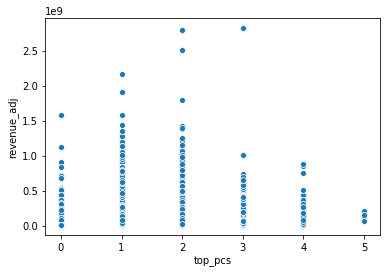

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


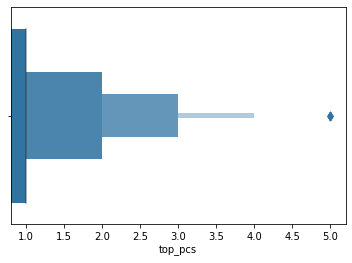

In [93]:
# Creating a new column called 'top_pcs' that will represent the number of top production companies 
# involved in a movie

movies['top_pcs'] = [len(set(i) & set(top_pcs)) for i in movies['production_companies']]
sns.scatterplot(x='top_pcs', y='revenue_adj', data=movies)
plt.show()

sns.boxenplot(x='top_pcs', data=movies)

## Book Film Adaptations

I'll import a list of books that have been adapted into movies and create a dummy variable, 'book_films', which will contain a one if the movie has been adapted from a book and a zero otherwise.

In [94]:
# Importing the book__film_adaptations 

book_film_adaptations = pd.read_csv('book_film_adaptations.csv')
book_films = pd.DataFrame(book_film_adaptations)


# Removing *s and years
book_films['Film_adaptation'] = book_films['Film_adaptation'].apply(lambda x: x.strip('*'))
book_films['Film_adaptation'] = book_films['Film_adaptation'].str.replace(u'\xa0', u' ')
titles_split = book_films['Film_adaptation'].str.split('(', n=1, expand=True)
book_films['Film_adaptation'] = titles_split[0]
book_films['Film_adaptation'] = book_films['Film_adaptation'].str.rstrip()
# book_films['Film_adaptation'] = book_films['Film_adaptation'].str.split('(')

# book_films['Film_adaptation'] = book_films['Film_adaptation'].apply(lambda x: x.split(' (', 1)[0])

# Converting the series to a list so we can compare it to the cast lists
book_films = book_films['Film_adaptation'].tolist()
print('\n Testing the list: ', book_films[72:77], '\n')

movies['books'] = [len(set(i) & set(book_films)) for i in movies['original_title']]
print('Number of movies adapted from books: \n', movies.books.value_counts())


 Testing the list:  ['Tom Sawyer', ' Huckleberry Finn', 'Tom Sawyer', 'The Adventures of Mark Twain', 'Back to Hannibal: The Return of Tom Sawyer and Huckleberry Finn'] 

Number of movies adapted from books: 
 0    4448
1     397
Name: books, dtype: int64


## Normalizing and Testing the Normality of the New Features

We can see that the T-values for the new features aren't terribly large.

In [95]:
# Normalizing new feature

movies['norm_winsorized_top_1000_actors'] = normalize(np.array(winsorize(movies['top_1000_actors'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies['norm_winsorized_top_pcs'] = normalize(np.array(winsorize(movies['top_pcs'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)

features_to_test = ['norm_winsorized_top_1000_actors', 'top_1000_actors', 'norm_winsorized_top_pcs', 'top_pcs']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))


Testing for normality on norm_winsorized_top_1000_actors:
Jarque-Bera test statistics for norm_winsorized_top_1000_actors is 285.42747771938065 and p value is 0.0
Normality test statistics for norm_winsorized_top_1000_actors is 3720.273542559928 and p value is 0.0

Testing for normality on top_1000_actors:
Jarque-Bera test statistics for top_1000_actors is 198.22594183942633 and p value is 0.0
Normality test statistics for top_1000_actors is 625.0857548984999 and p value is 1.8380315660955484e-136

Testing for normality on norm_winsorized_top_pcs:
Jarque-Bera test statistics for norm_winsorized_top_pcs is 211.70858104981414 and p value is 0.0
Normality test statistics for norm_winsorized_top_pcs is 1224.3810764399386 and p value is 1.3459451990275134e-266

Testing for normality on top_pcs:
Jarque-Bera test statistics for top_pcs is 891.7225814193965 and p value is 0.0
Normality test statistics for top_pcs is 601.0081632421258 and p value is 3.1098222218255595e-131



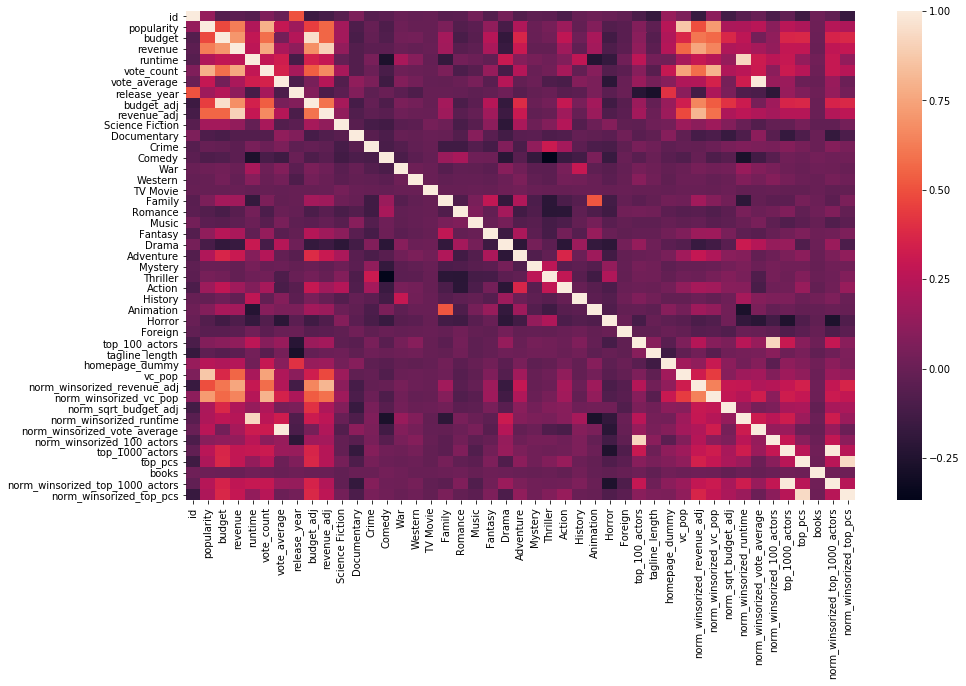

In [96]:
plt.figure(figsize=(15,9))
sns.heatmap(movies.corr())

In [98]:
print(movies.describe())

              id  popularity        budget        revenue  runtime  \
count   4845.000    4845.000      4845.000       4845.000 4845.000   
mean   44480.637       1.046  29596501.140   89286753.677  107.823   
std    72237.599       1.357  40525081.586  162131011.345   18.965   
min        5.000       0.001         0.000          2.000   26.000   
25%     8279.000       0.388   1746964.000    7770731.000   95.000   
50%    12151.000       0.681  15000000.000   31899000.000  104.000   
75%    43947.000       1.211  40000000.000   99965753.000  117.000   
max   417859.000      32.986 425000000.000 2781505847.000  254.000   

       vote_count  vote_average  release_year    budget_adj    revenue_adj  \
count    4845.000      4845.000      4845.000      4845.000       4845.000   
mean      436.585         6.148      2000.915  35114640.514  115527954.391   
std       806.742         0.799        11.572  43407143.801  198865194.898   
min        10.000         2.100      1960.000         0.0

## Testing Our Models With Three New Variables

In [99]:
features3 = movies[['budget_adj', 'vc_pop', 'runtime', 'Adventure', 'top_1000_actors', 'top_pcs', 'books',
                    'vote_average', 'Action', 'Family', 'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction',
                    'War', 'tagline_length', 'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy',
                    'Crime', 'Music', 'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]
target3 = movies['revenue_adj']
X3_train, X3_test, Y3_train, Y3_test = train_test_split(features3, target3, test_size = .3, random_state = 465)


linear_features3 = movies[['norm_sqrt_budget_adj', 'norm_winsorized_vc_pop', 'norm_winsorized_runtime', 'Adventure', 'norm_winsorized_top_1000_actors',
                    'norm_winsorized_vote_average', 'norm_winsorized_top_pcs', 'books','Action', 'Family', 'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction',
                    'War', 'tagline_length', 'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy',
                    'Crime', 'Music', 'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]
linear_target3 = movies['norm_winsorized_revenue_adj'] ## for Linear Regression Models
linear_X3_train, linear_X3_test, linear_Y3_train, linear_Y3_test = train_test_split(linear_features3, linear_target3,
                test_size = .3, random_state = 465) ## for OLS


## OLS

The OLS model remains virtually the same with R-squareds of 0.579 and 0.566 for the training and testing sets.

In [100]:
print("The number of observations in training set is {}".format(linear_X3_train.shape[0]))
print("The number of observations in test set is {}".format(linear_X3_test.shape[0]))

# We fit an OLS model using sklearn
linear_X3_train_const = sm.add_constant(linear_X3_train)
linear_X3_test_const = sm.add_constant(linear_X3_test)
ols = LinearRegression().fit(linear_X3_train_const, linear_Y3_train)

results_train = sm.OLS(linear_Y3_train, linear_X3_train_const).fit()
results_test = sm.OLS(linear_Y3_test, linear_X3_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y3_preds_train = ols.predict(linear_X3_train_const)
Y3_preds_test = ols.predict(linear_X3_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(linear_X3_train_const, linear_Y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(linear_X3_test_const, linear_Y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y3_test, Y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y3_test, Y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y3_test, Y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y3_test - Y3_preds_test) / linear_Y3_test)) * 100))

The number of observations in training set is 3391
The number of observations in test set is 1454
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.573
Model:                                     OLS   Adj. R-squared:                  0.569
Method:                          Least Squares   F-statistic:                     150.4
Date:                         Wed, 18 Dec 2019   Prob (F-statistic):               0.00
Time:                                 16:21:56   Log-Likelihood:                 11986.
No. Observations:                         3391   AIC:                        -2.391e+04
Df Residuals:                             3360   BIC:                        -2.372e+04
Df Model:                                   30                                         
Covariance Type:                     nonrobust                                         
                      

## OLS with Cross Validation

With an MSE of 5.067e-05 and an R-squared of 0.562, this model is still improving. 

In [101]:
cross_val_scores = cross_val_score(LinearRegression(), linear_features3, linear_target3, cv=10)
nmse_cross_val_scores = cross_val_score(LinearRegression(), linear_features3, linear_target3, cv=10, scoring='neg_mean_squared_error')
print('OLS R-Squared Score: ', cross_val_scores.mean())
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n')
print('Negative MSE Score: ', nmse_cross_val_scores.mean())
print('Negative MSE Scores with Cross Validation: ', nmse_cross_val_scores)

OLS R-Squared Score:  0.5624961054789407
R-Squared Scores with Cross Validation:  [0.61506693 0.61363414 0.6607498  0.64247973 0.61404069 0.60953718
 0.62371034 0.43683347 0.42482881 0.38407997]


Negative MSE Score:  -5.067010225203811e-05
Negative MSE Scores with Cross Validation:  [-5.15271112e-05 -4.45729725e-05 -3.76661750e-05 -4.33314055e-05
 -4.66107533e-05 -3.37078649e-05 -4.03453325e-05 -6.53821987e-05
 -6.29077784e-05 -8.06494306e-05]


## Ridge Regression with Training/Testing Sets

Exact same metrics as Ridge with cross validation, which means that our model isn't overfitting.

In [102]:
ridgeregr = Ridge(alpha=0.1) 
ridgeregr.fit(linear_X3_train, linear_Y3_train)

# We are making predictions here
Y3_preds_train = ridgeregr.predict(linear_X3_train)
Y3_preds_test = ridgeregr.predict(linear_X3_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(linear_X3_train, linear_Y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(linear_X3_test, linear_Y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y3_test, Y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(linear_Y3_test, Y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y3_test, Y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y3_test - Y3_preds_test) / linear_Y3_test)) * 100))

R-squared of the model on the training set is: 0.5487076410520211
-----Test set statistics-----
R-squared of the model on the test set is: 0.5563630933563191
Mean absolute error of the prediction is: 0.005438151768070948
Mean squared error of the prediction is: 5.1090071044317904e-05
Root mean squared error of the prediction is: 0.007147731881115708
Mean absolute percentage error of the prediction is: 7855.476200500496


## Ridge Regression with Cross Validation
This model also improves slightly with the new features.

In [103]:
ridgeCV = RidgeCV(alphas=(0.1, 10), cv=5)
ridgeCV.fit(linear_features3, linear_target3)

# We are making predictions here
Y3_preds = ridgeCV.predict(linear_features3)


print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(ridgeCV.score(linear_features3, linear_target3)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target3, Y3_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target3, Y3_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target3, Y3_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target3 - Y3_preds) / linear_target3)) * 100))

-----Test set statistics-----
R-squared of the model is: 0.5583446885826278
Mean absolute error of the prediction is: 0.005343929073743366
Mean squared error of the prediction is: 5.134190121797757e-05
Root mean squared error of the prediction is: 0.007165326316224375
Mean absolute percentage error of the prediction is: 17224.71493797844


## ElasticNet with Training & Testing Sets

Slightly better than last model.

In [104]:
# Using GridSearchCV to find the best parameters for the ElasticNEt
en_gsc = GridSearchCV(
        estimator=ElasticNetCV(),
        param_grid={'l1_ratio': [0.1, 0.3, 0.7, 1]}, verbose=1)
#                     ,
grid_result = en_gsc.fit(linear_features3, linear_target3)
best_params = grid_result.best_params_
best_en = ElasticNetCV(l1_ratio=best_params['l1_ratio'])

print('Parameters for the best ElasticNet Model: ', best_en)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Parameters for the best ElasticNet Model:  ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.1s finished


In [112]:
elasticregr = ElasticNet(l1_ratio=1, alpha=0) 
elasticregr.fit(linear_X3_train, linear_Y3_train)

# We are making predictions here
Y3_preds_train = elasticregr.predict(linear_X3_train)
Y3_preds_test = elasticregr.predict(linear_X3_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(linear_X3_train, linear_Y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(linear_X3_test, linear_Y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y3_test, Y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y3_test, Y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y3_test, Y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y3_test - Y3_preds_test) / linear_Y3_test)) * 100))

R-squared of the model on the training set is: 0.5731384200348835
-----Test set statistics-----
R-squared of the model on the test set is: 0.5798565466002764
Mean absolute error of the prediction is: 0.005162190779576688
Mean squared error of the prediction is: 4.8384520227117335e-05
Root mean squared error of the prediction is: 0.006955898232947154
Mean absolute percentage error of the prediction is: 6351.337089166066


In [113]:
elasticregrCV = ElasticNetCV(l1_ratio=1, n_alphas=1, cv=10) 
elasticregrCV.fit(linear_features3, linear_target3)

# We are making predictions here
Y3_preds = elasticregrCV.predict(linear_features3)

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(linear_features3, linear_target3)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target3, Y3_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target3, Y3_preds)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(linear_target3, Y3_preds))))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target3, Y3_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target3 - Y3_preds) / linear_target3))))

-----Test set statistics-----
R-squared of the model on the test set is: 0.5134900823520214
Mean absolute error of the prediction is: 0.005696238550882305
Mean squared error of the prediction is: 5.655619549391977e-05
Root mean squared error of the prediction is: 0.007520385328819247
Root mean squared error of the prediction is: 0.007520385328819247
Mean absolute percentage error of the prediction is: 167.17863082982063


## Random Forests

Random Forests doesn't perform much better than the last round with an MSE of 1.6697e+16.

In [107]:
rf_gsc = GridSearchCV(
        estimator=ensemble.RandomForestRegressor(),
        param_grid={
            'max_depth': [80, 90, 100],
            'max_features': [2, 3],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [100, 500, 1000]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

rf_gsc.fit(features3, target3)
best_params = rf_gsc.best_params_
# svr_gsc.best_estimator_
best_rf = ensemble.RandomForestRegressor(max_depth=best_params['max_depth'], max_features=best_params["max_features"],
                                         min_samples_leaf=best_params["min_samples_leaf"], min_samples_split=best_params["min_samples_split"],
                                         n_estimators=best_params['n_estimators'],verbose=False)

print('Parameters for the best Support Vector Model: ', best_rf)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 15.8min finished


Parameters for the best Support Vector Model:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)


In [108]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)
rfr.fit(X3_train, Y3_train)

Y3_preds_train = rfr.predict(X3_train)
Y3_preds_test = rfr.predict(X3_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X3_train, Y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X3_test, Y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y3_test, Y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y3_test, Y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y3_test, Y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y3_test - Y3_preds_test) / Y3_test)) * 100))

R-squared of the model on the training set is: 0.7204974691488331
-----Test set statistics-----
R-squared of the model on the test set is: 0.6004027074799397
Mean absolute error of the prediction is: 62933772.84828203
Mean squared error of the prediction is: 1.364390070159989e+16
Root mean squared error of the prediction is: 116807108.95146704
Mean absolute percentage error of the prediction is: 8677.1838004772


In [109]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)

cross_val_scores = cross_val_score(rfr, features3, target3, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(rfr, features3, target3, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.5991625364081082
Cross Validation Scores:  [0.57365043 0.66734264 0.7473982  0.71578112 0.6028985  0.70757624
 0.69350313 0.52255542 0.49106554 0.26985413]


Mean Negative MSE:  -1.669735845245113e+16
Cross Validation MSE Scores:  [-3.41652078e+16 -9.22267266e+15 -7.51116210e+15 -1.12980818e+16
 -1.67111088e+16 -6.61641096e+15 -9.95241469e+15 -1.44140678e+16
 -1.31572819e+16 -4.39251760e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.9s finished


## Gradient Boosting

While the discrepancy between the R-squareds in the training and tests sets differ greatly, the R-squared for the test set for the Gradient Boosting model is much better than the OLS, Ride, and ElasticNet models. However, the previous set of features produced a slightly higher R-squared and lower evaluation metrics.

In [110]:
# Using GridSearchCV to find the best parameters for the Gradient Boosting
gbr_gsc = GridSearchCV(
        estimator= ensemble.GradientBoostingRegressor(loss='ls'),
        param_grid={
            'learning_rate': [0.01, 0.1, 1],
            'n_estimators': [100, 500],
            'max_depth': [2, 3, 4]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_result = gbr_gsc.fit(features3, target3)
best_params = grid_result.best_params_
best_gbr = ensemble.GradientBoostingRegressor(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], 
                    max_depth=best_params['max_depth'],  tol=0.001)
print(best_gbr)
# fitting the model with the best parameters
best_gbr.fit(features3, target3)

Y3_preds_train = best_gbr.predict(X3_train)
Y3_preds_test = best_gbr.predict(X3_test)

print('\n')
print("R-squared of the model on the training set is: {}".format(best_gbr.score(X3_train, Y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(best_gbr.score(X3_test, Y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y3_test, Y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y3_test, Y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y3_test, Y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y3_test - Y3_preds_test) / Y3_test)) * 100))

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.8min finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


R-squared of the model on the training set is: 0.8712757777756686
-----Test set statistics-----
R-squared of the model on the test set is: 0.8560082312296682
Mean absolute error of the prediction is: 42472690.376119904
Mean squared error of the prediction is: 4916473238745767.0
Root mean squared error of the prediction is: 70117567

In [111]:
cross_val_scores = cross_val_score(best_gbr, features3, target3, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(best_gbr, features3, target3, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.65913755865185
Cross Validation Scores:  [0.66316432 0.63645559 0.7620286  0.74361676 0.73551268 0.72106754
 0.7795572  0.59212671 0.58100719 0.37683899]


Mean Negative MSE:  -1.4070810156562662e+16
Cross Validation MSE Scores:  [-2.66931162e+16 -1.00639391e+16 -7.33945951e+15 -1.02609182e+16
 -1.14501897e+16 -6.18911597e+15 -7.29497850e+15 -1.26510467e+16
 -1.13903106e+16 -3.73750271e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.5s finished


## Summary of Third Round

|Model | R-Squared Value |Mean Squared Error
------|------|------|
|OLS (CV) |0.562 | 5.067e-05
|Ridge Regression (CV) |0.542 |5.134e-05
|ElasticNet (CV) |0.513 | 5.655e-05
|Random Forests (CV) |0.599 | 1.669e+16
|Gradient Boosting (CV)|0.659|1.407e+16
|XGBoost (CV)|0.606| 

# Summary

To recall, the goal of this project was to predict the adjusted revenue of a movie given the dataset I had. While I started with nearly 11,000 movies, I immediately had to cut 6,000 as they did not have information for the target variable. I cleaned the data, transformed the features, and ran seven different types of models on ththe data using three different sets of features.

# Conclusions

In all three rounds of testing, the Support Vector Machines model greatly outperformed the others. It was best in round two when all of the original features were used, with a score of 0.97 and mean square errors ranging from 0.056 to 0.146. The model ran best using the smallest options for the C, epsilon, and gamma parameters, which indicates to me that the model is very specific and likely overfitting. Because the mean squared error was at most 0.146, it's still a good model for the data.

In [ ]:
'budget_adj', 'norm_winsorized_vc_pop', 'norm_winsorized_top_pcs', 'runtime',

In [ ]:
# heat map with correlation matrix